In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import dlib
import glob
from google.colab.patches import cv2_imshow

images = [cv2.imread(file) for file in glob.glob("/content/drive/MyDrive/Images/*.png")]
conf=0.4
dnn_path="/content/drive/MyDrive/Thesis_detection/weights/res10_300x300_ssd_iter_140000.caffemodel"
predictor = dlib.shape_predictor("/content/drive/MyDrive/Thesis_detection/dlib/shape_predictor_68_face_landmarks.dat")

In [ ]:
def get_face_detector(modelFile = "/content/drive/MyDrive/Thesis_detection/weights/res10_300x300_ssd_iter_140000_fp16.caffemodel",
                      configFile = "/content/drive/MyDrive/Thesis_detection/weights/deploy.prototxt"):
    """
    Get the face detection caffe model of OpenCV's DNN module

    Parameters
    ----------
    modelFile : string, optional
        Path to model file. The default is "models/res10_300x300_ssd_iter_140000.caffemodel".
    configFile : string, optional
        Path to config file. The default is "models/deploy.prototxt".
    Returns
    -------
    model : dnn_Net
    """
    print("Inside get_face_detector")
    modelFile = "/content/drive/MyDrive/Thesis_detection/weights/res10_300x300_ssd_iter_140000_fp16.caffemodel"
    configFile = "/content/drive/MyDrive/Thesis_detection/weights/deploy.prototxt"
    model = cv2.dnn.readNetFromCaffe(configFile, modelFile)
    return model

def find_faces(img, model):
    """
    Find the faces in an image

    Parameters
    ----------
    img : np.uint8
        Image to find faces from
    model : dnn_Net
        Face detection model
    Returns
    -------
    faces : list
        List of coordinates of the faces detected in the image
    """
    print("Inside find_faces")
    h, w = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0,
	(300, 300), (104.0, 177.0, 123.0))
    model.setInput(blob)
    res = model.forward()
    faces = []
    for i in range(res.shape[2]):
        confidence = res[0, 0, i, 2]
        if confidence > 0.5:
            box = res[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x1, y1) = box.astype("int")
            faces.append([x, y, x1, y1])
    return faces

def get_landmark_model(saved_model='/content/drive/MyDrive/Thesis_detection/pose_model'):
    """
    Get the facial landmark model.
    Original repository: https://github.com/yinguobing/cnn-facial-landmark
    Parameters
    ----------
    saved_model : string, optional
        Path to facial landmarks model. The default is 'models/pose_model'.
    Returns
    -------
    model : Tensorflow model
        Facial landmarks model
    """
    print("Inside get_landmark_model")
    #model = keras.models.load_model(saved_model)
    #base_model = tf.keras.models.load_model(path)
    model = tf.saved_model.load(saved_model)

    return model

def get_square_box(box):
    """Get a square box out of the given box, by expanding it."""
    print("Inside get_square_box")
    left_x = box[0]
    top_y = box[1]
    right_x = box[2]
    bottom_y = box[3]

    box_width = right_x - left_x
    box_height = bottom_y - top_y

    # Check if box is already a square. If not, make it a square.
    diff = box_height - box_width
    delta = int(abs(diff) / 2)

    if diff == 0:                   # Already a square.
        return box
    elif diff > 0:                  # Height > width, a slim box.
        left_x -= delta
        right_x += delta
        if diff % 2 == 1:
            right_x += 1
    else:                           # Width > height, a short box.
        top_y -= delta
        bottom_y += delta
        if diff % 2 == 1:
            bottom_y += 1

    # Make sure box is always square.
    assert ((right_x - left_x) == (bottom_y - top_y)), 'Box is not square.'

    return [left_x, top_y, right_x, bottom_y]

def move_box(box, offset):
        """Move the box to direction specified by vector offset"""
        left_x = box[0] + offset[0]
        top_y = box[1] + offset[1]
        right_x = box[2] + offset[0]
        bottom_y = box[3] + offset[1]
        return [left_x, top_y, right_x, bottom_y]

def detect_marks(img, model, face):
    """
    Find the facial landmarks in an image from the faces
    Parameters
    ----------
    img : np.uint8
        The image in which landmarks are to be found
    model : Tensorflow model
        Loaded facial landmark model
    face : list
        Face coordinates (x, y, x1, y1) in which the landmarks are to be found
    Returns
    -------
    marks : numpy array
        facial landmark points
    """
    print("Inside dtect_makrs")
    offset_y = int(abs((face[3] - face[1]) * 0.1))
    box_moved = move_box(face, [0, offset_y])
    facebox = get_square_box(box_moved)

    face_img = img[facebox[1]: facebox[3],
                     facebox[0]: facebox[2]]
    face_img = cv2.resize(face_img, (128, 128))
    face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)

    # # Actual detection.
    predictions = model.signatures["predict"](
        tf.constant([face_img], dtype=tf.uint8))

    # Convert predictions to landmarks.
    marks = np.array(predictions['output']).flatten()[:136]
    marks = np.reshape(marks, (-1, 2))

    marks *= (facebox[2] - facebox[0])
    marks[:, 0] += facebox[0]
    marks[:, 1] += facebox[1]
    marks = marks.astype(np.uint)

    return marks

def draw_marks(image, marks, color=(0, 255, 0)):
    """
    Draw the facial landmarks on an image
    Parameters
    ----------
    image : np.uint8
        Image on which landmarks are to be drawn.
    marks : list or numpy array
        Facial landmark points
    color : tuple, optional
        Color to which landmarks are to be drawn with. The default is (0, 255, 0).
    Returns
    -------
    None.
    """
    for mark in marks:
        cv2.circle(image, (mark[0], mark[1]), 2, color, -1, cv2.LINE_AA)

Inside get_face_detector
Inside get_landmark_model


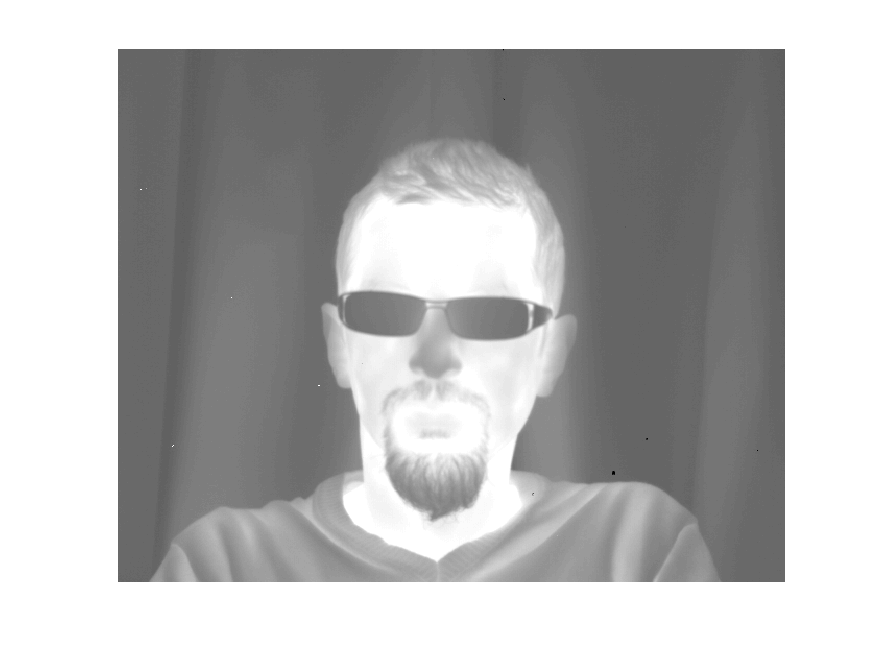

Inside find_faces
Inside dtect_makrs
Inside get_square_box


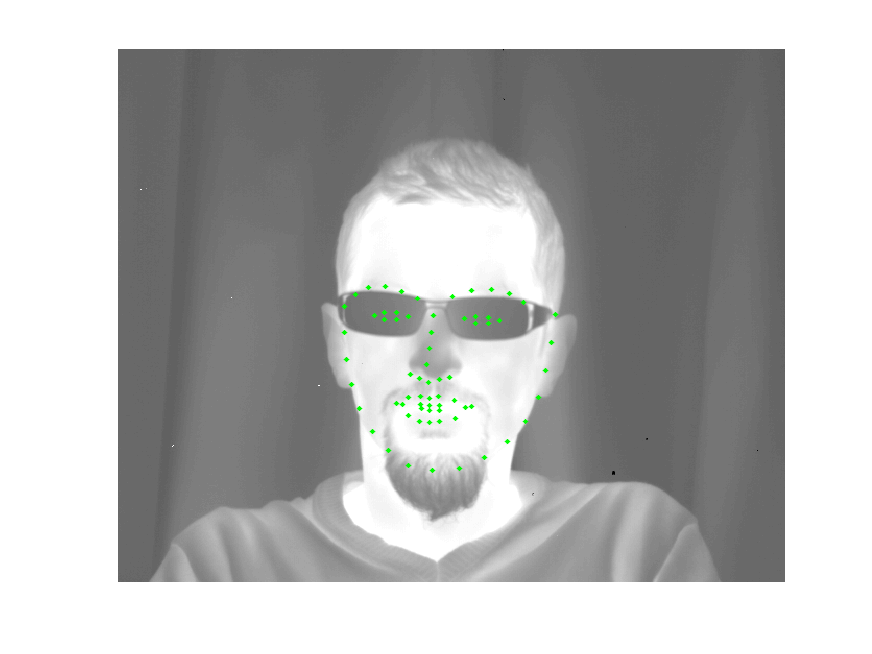

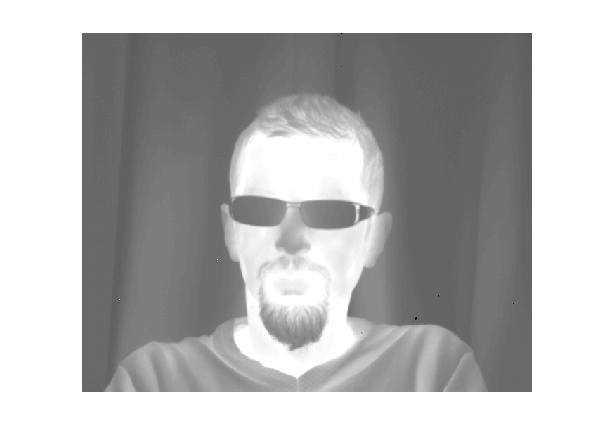

Inside find_faces
Inside dtect_makrs
Inside get_square_box


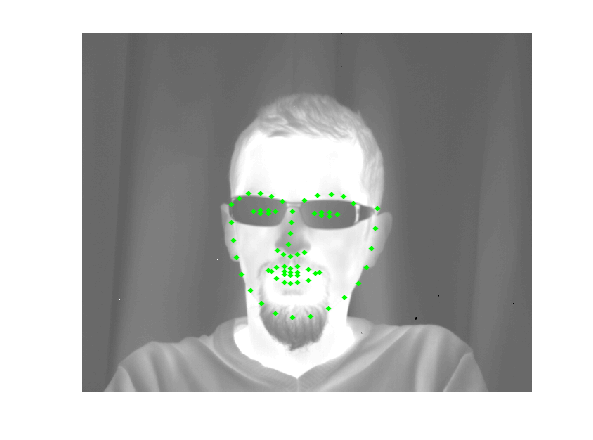

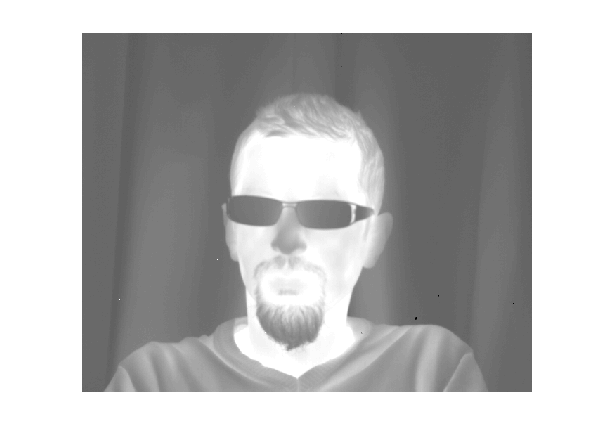

Inside find_faces
Inside dtect_makrs
Inside get_square_box


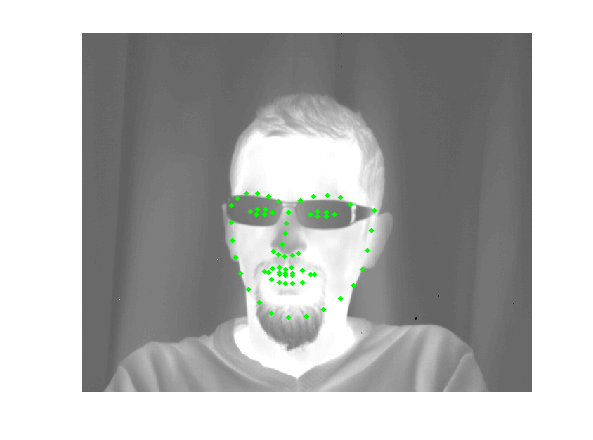

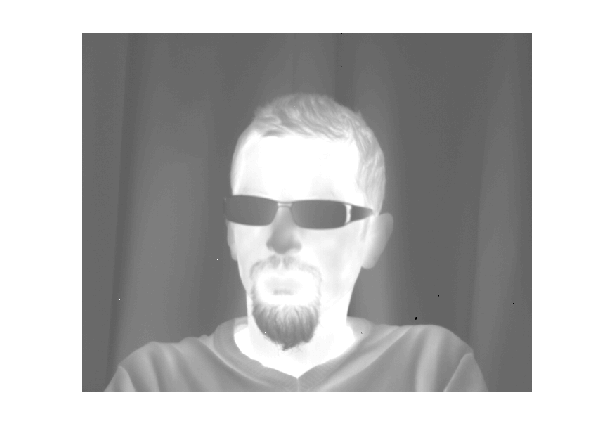

Inside find_faces
Inside dtect_makrs
Inside get_square_box


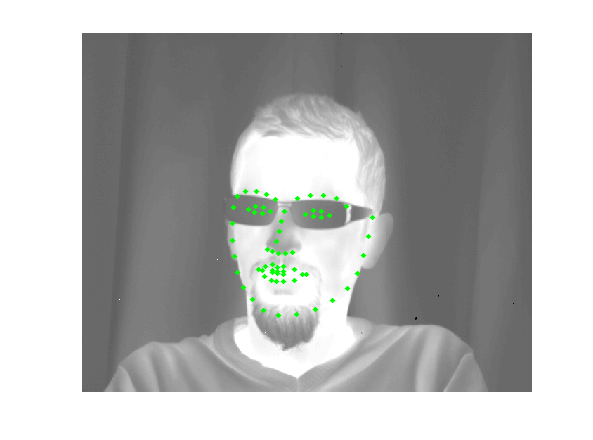

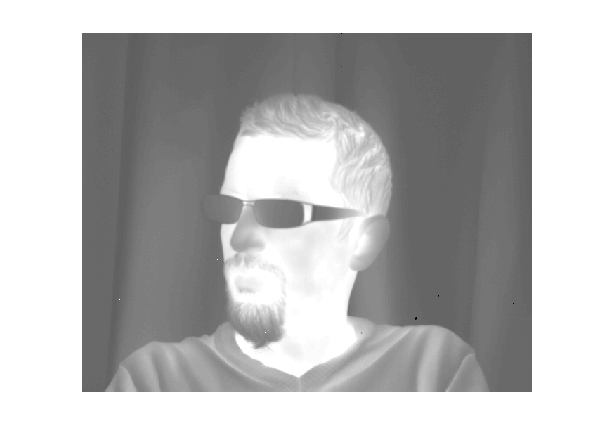

Inside find_faces
Inside dtect_makrs
Inside get_square_box


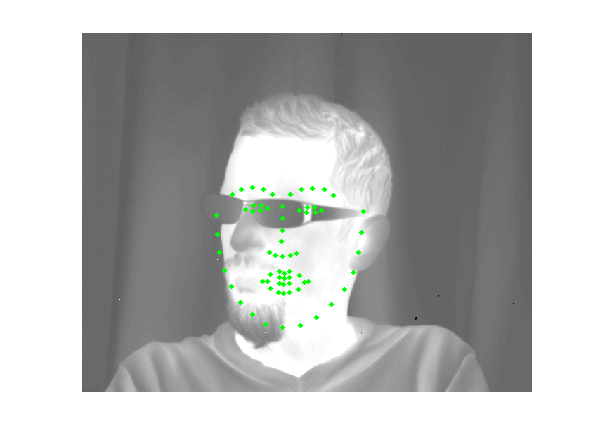

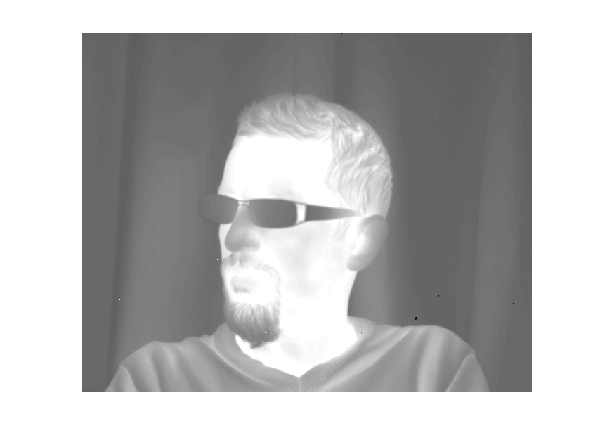

Inside find_faces
Inside dtect_makrs
Inside get_square_box


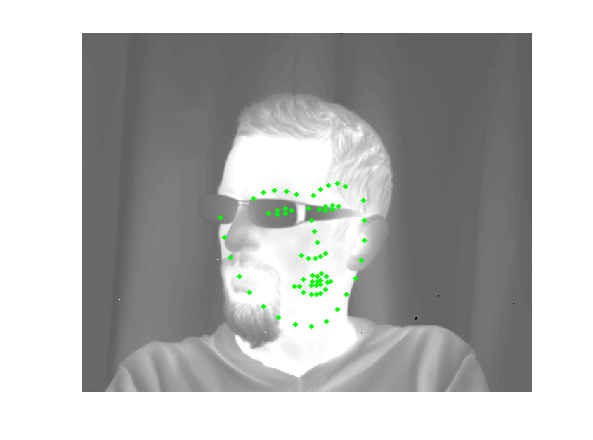

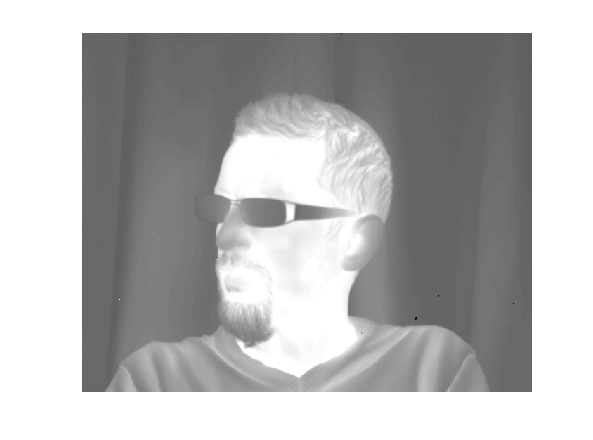

Inside find_faces
Inside dtect_makrs
Inside get_square_box


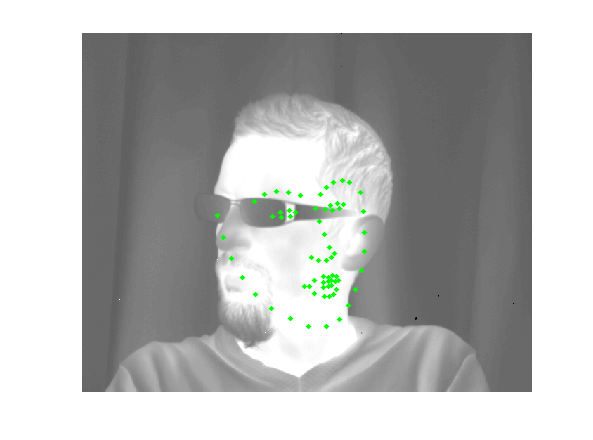

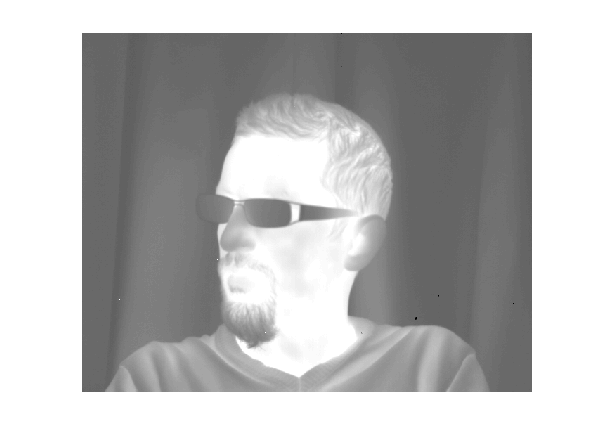

Inside find_faces
Inside dtect_makrs
Inside get_square_box


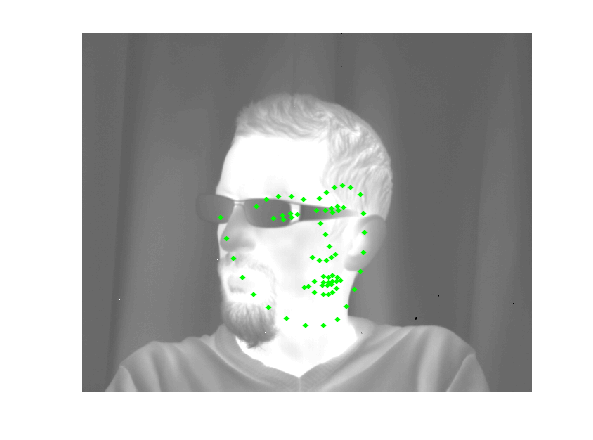

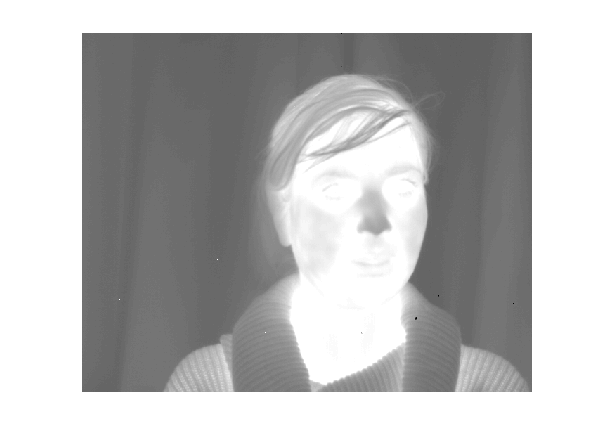

Inside find_faces
Inside dtect_makrs
Inside get_square_box


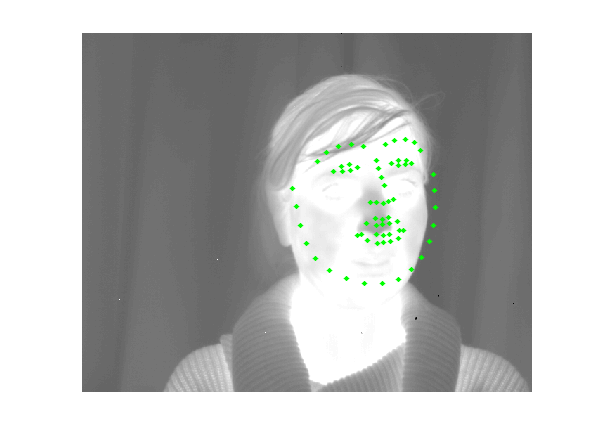

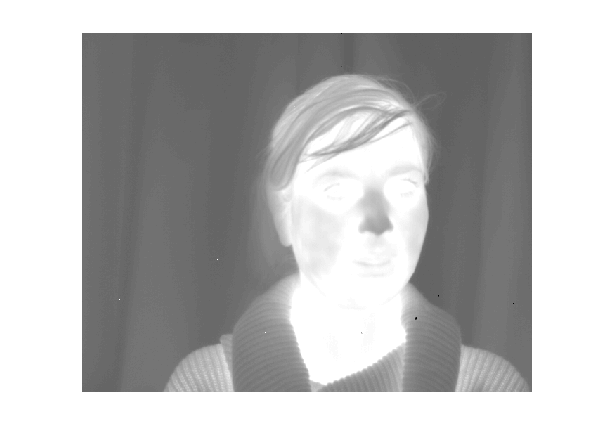

Inside find_faces
Inside dtect_makrs
Inside get_square_box


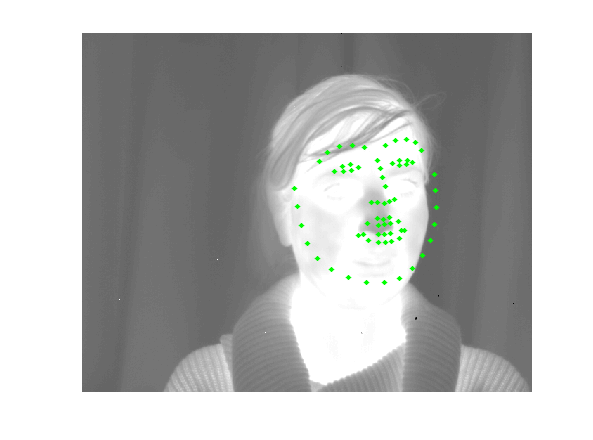

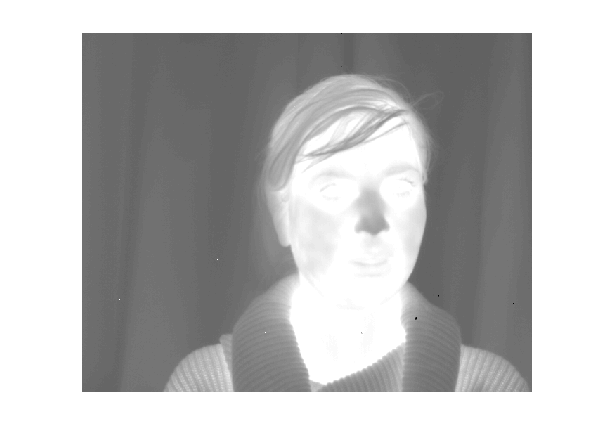

Inside find_faces
Inside dtect_makrs
Inside get_square_box


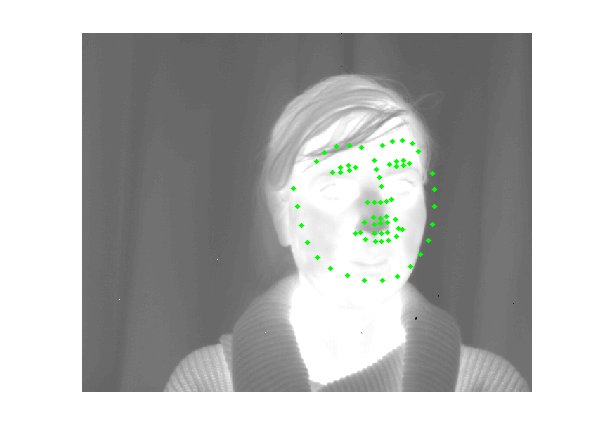

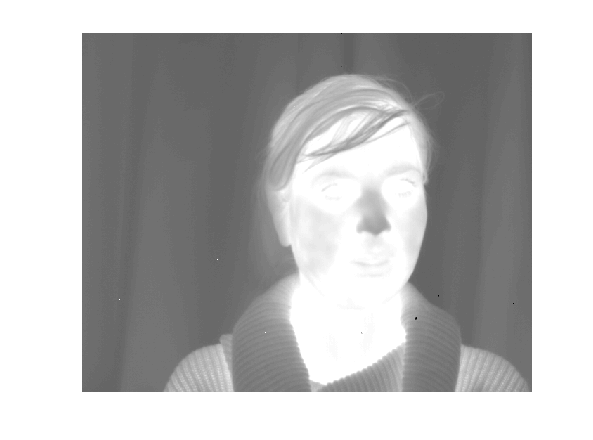

Inside find_faces
Inside dtect_makrs
Inside get_square_box


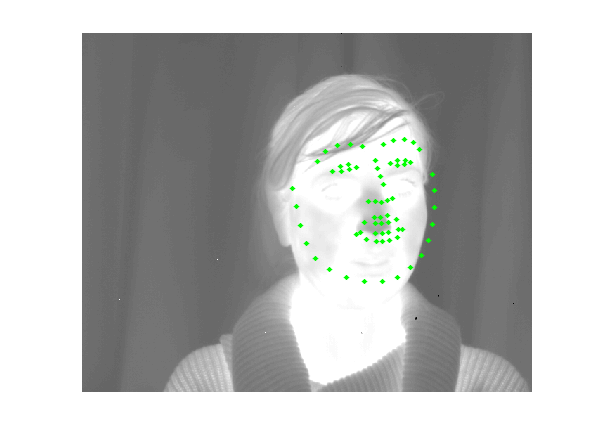

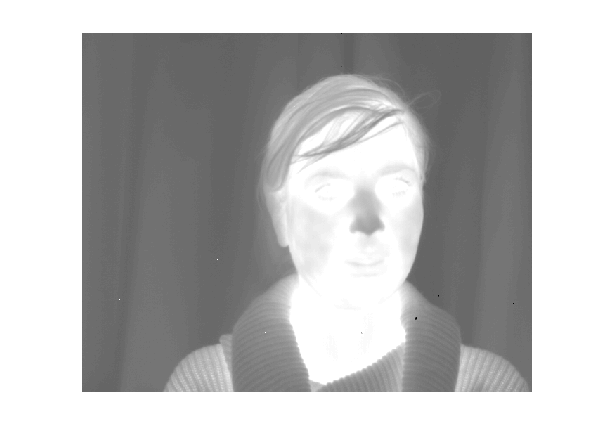

Inside find_faces
Inside dtect_makrs
Inside get_square_box


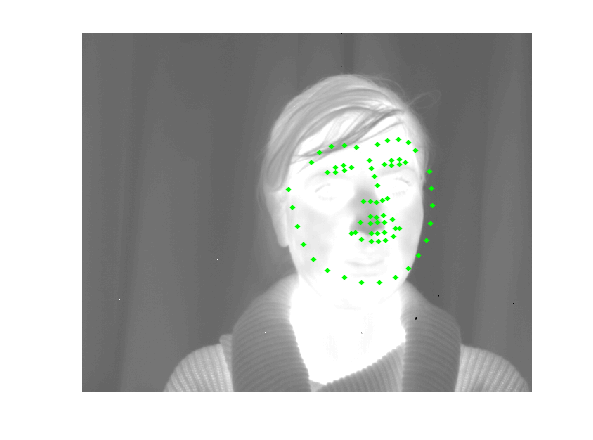

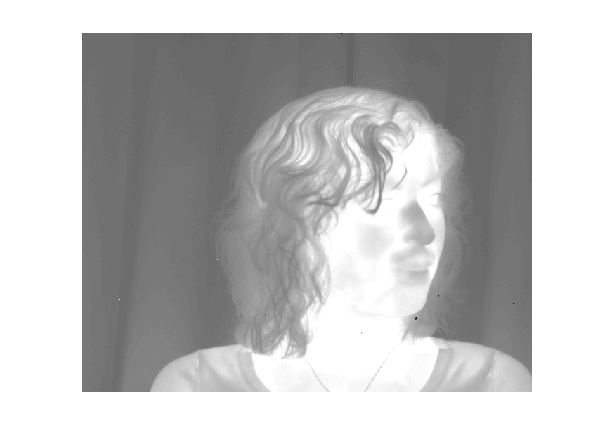

Inside find_faces
Inside dtect_makrs
Inside get_square_box


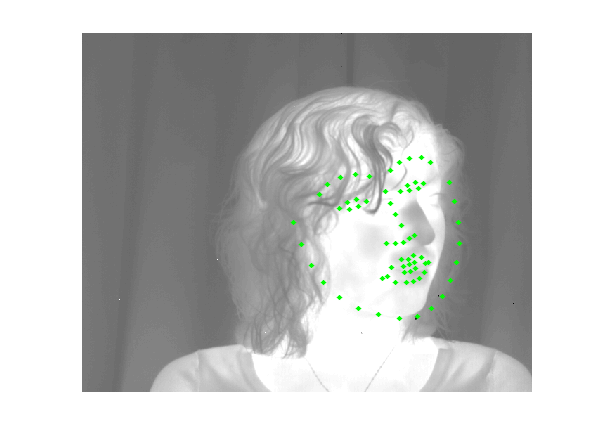

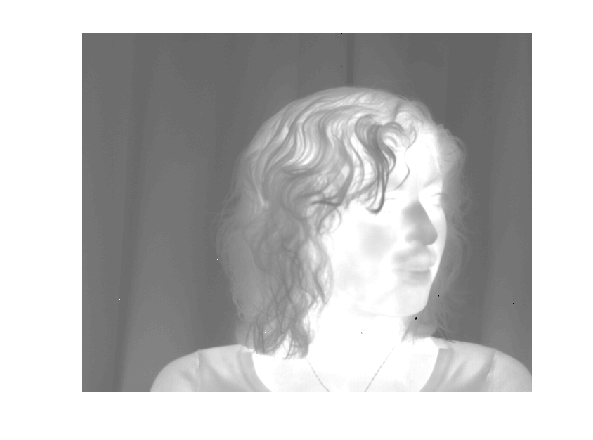

Inside find_faces
Inside dtect_makrs
Inside get_square_box


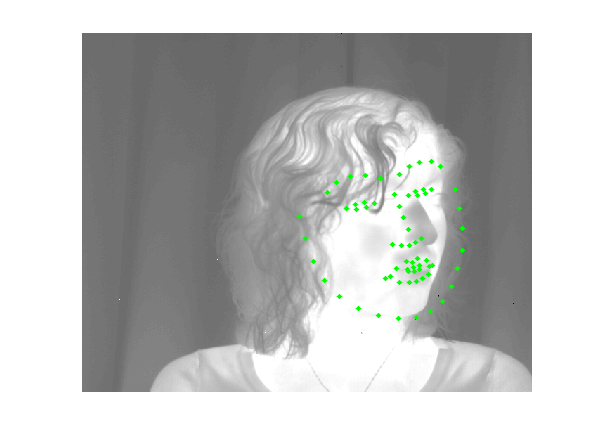

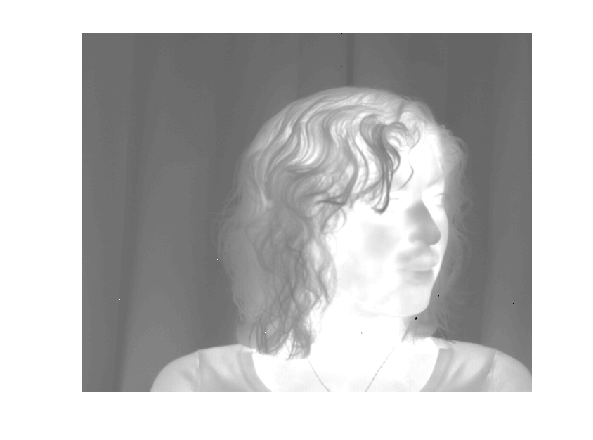

Inside find_faces
Inside dtect_makrs
Inside get_square_box


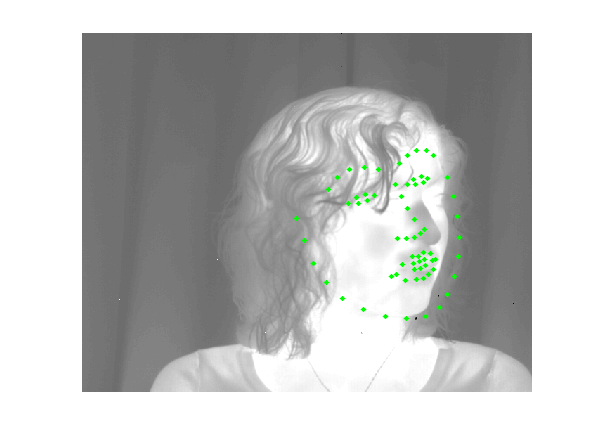

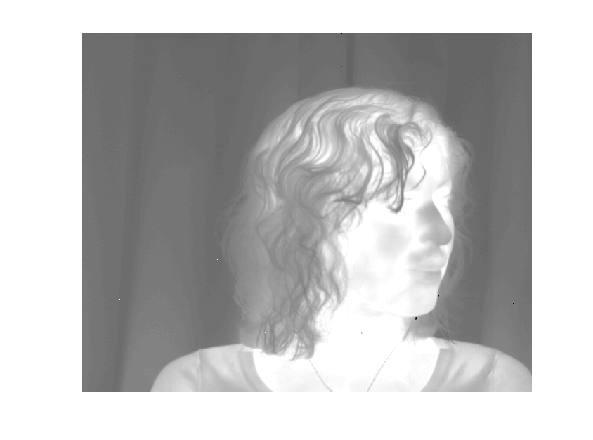

Inside find_faces
Inside dtect_makrs
Inside get_square_box


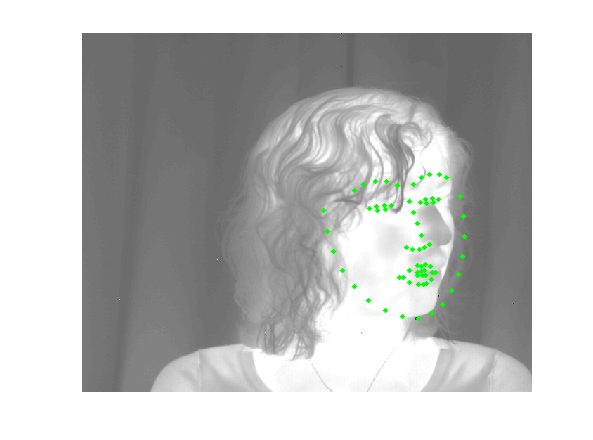

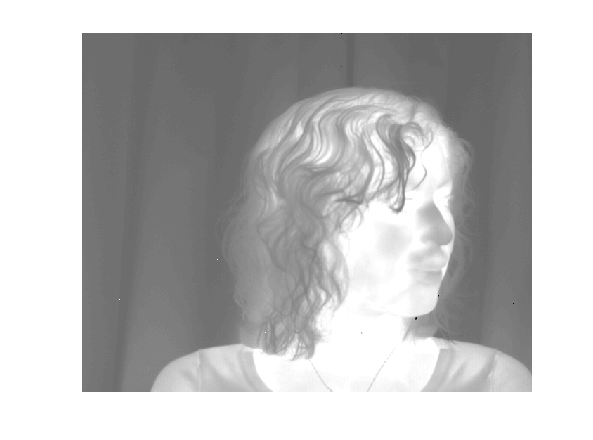

Inside find_faces
Inside dtect_makrs
Inside get_square_box


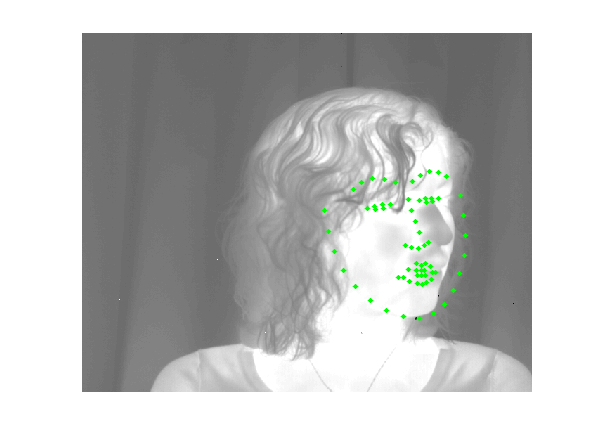

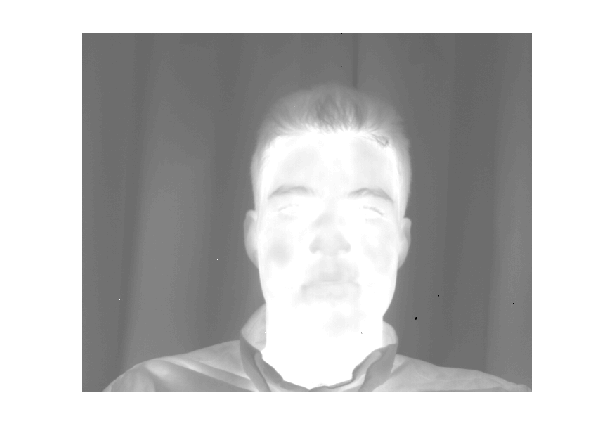

Inside find_faces
Inside dtect_makrs
Inside get_square_box


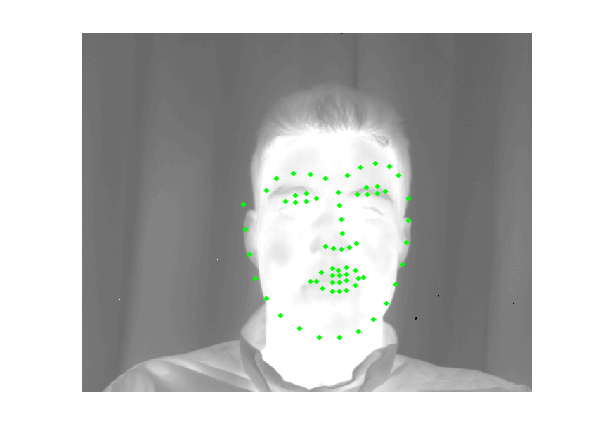

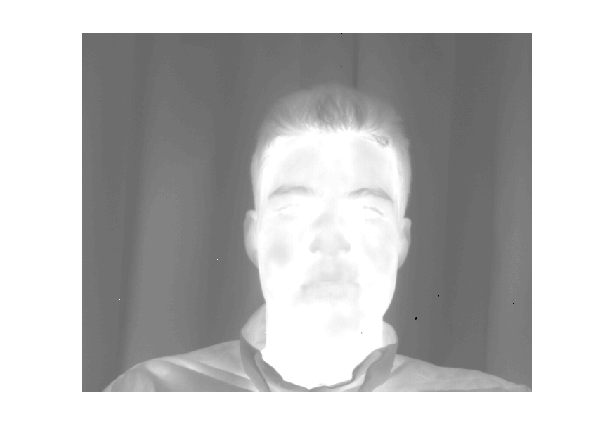

Inside find_faces
Inside dtect_makrs
Inside get_square_box


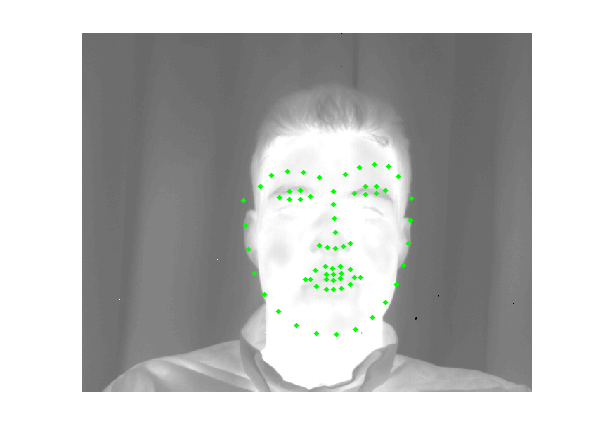

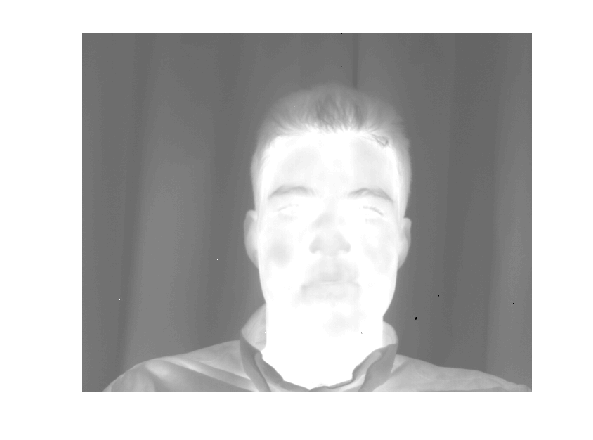

Inside find_faces
Inside dtect_makrs
Inside get_square_box


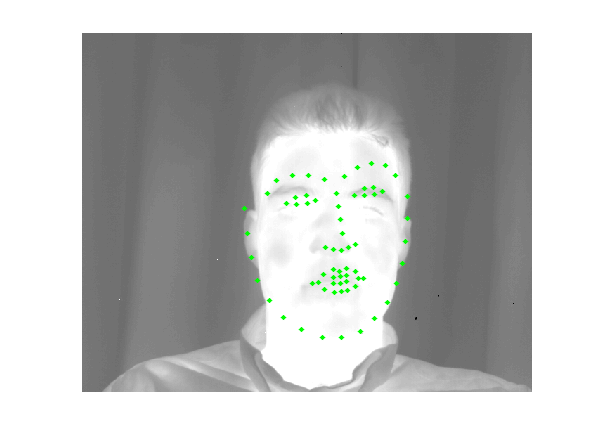

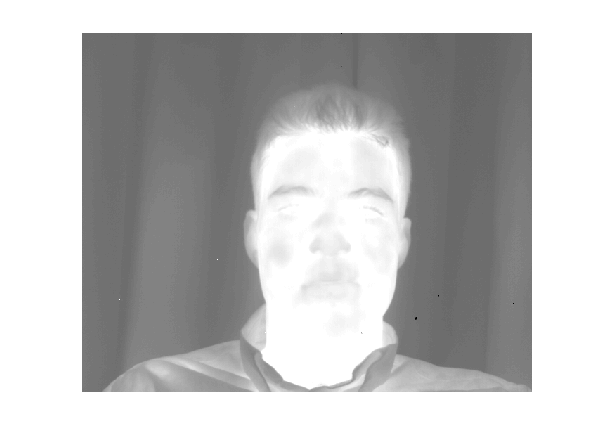

Inside find_faces
Inside dtect_makrs
Inside get_square_box


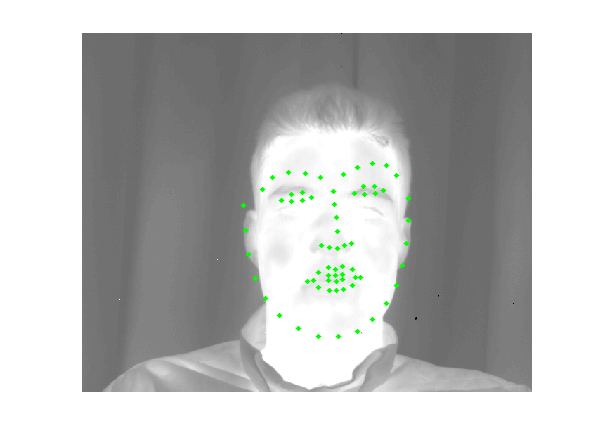

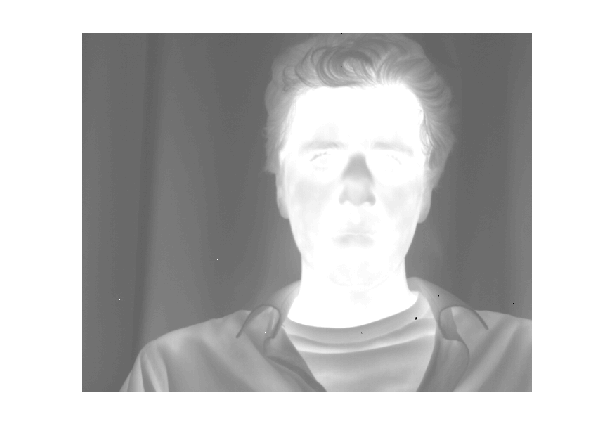

Inside find_faces
Inside dtect_makrs
Inside get_square_box


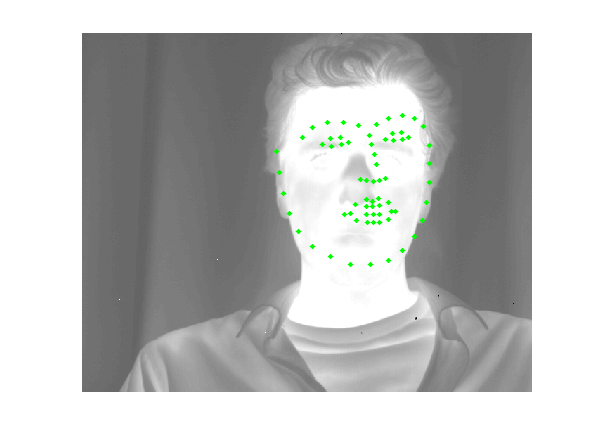

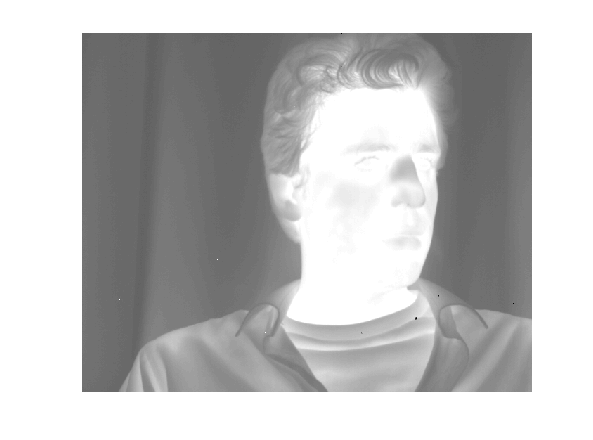

Inside find_faces
Inside dtect_makrs
Inside get_square_box


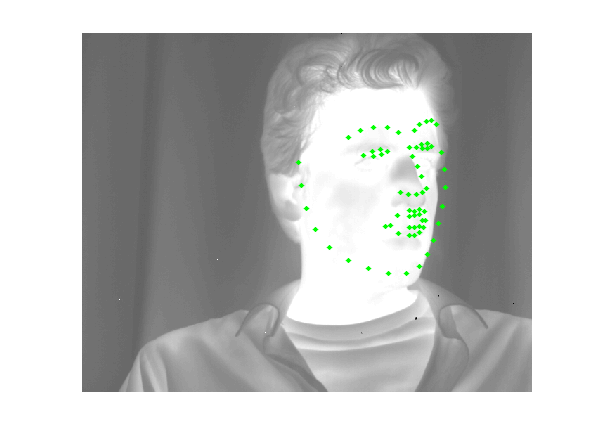

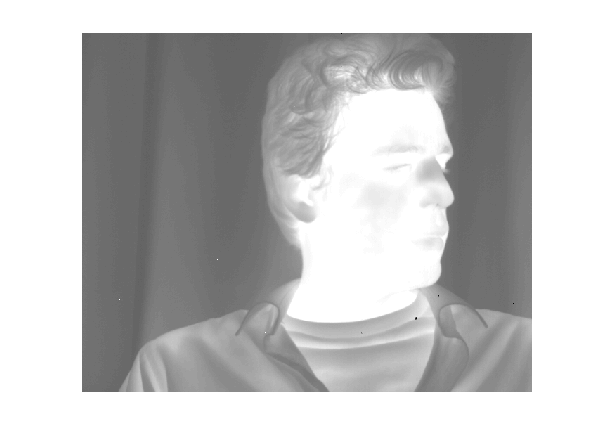

Inside find_faces
Inside dtect_makrs
Inside get_square_box


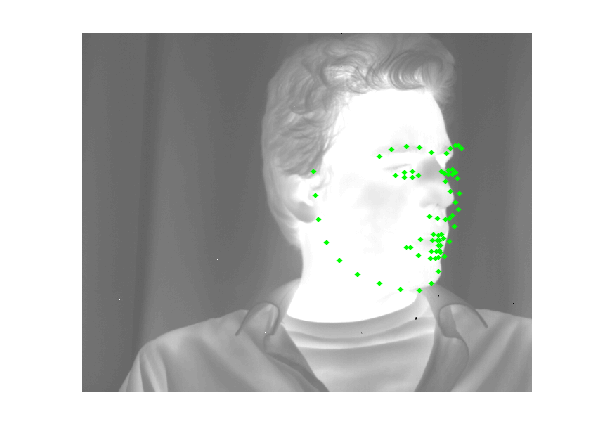

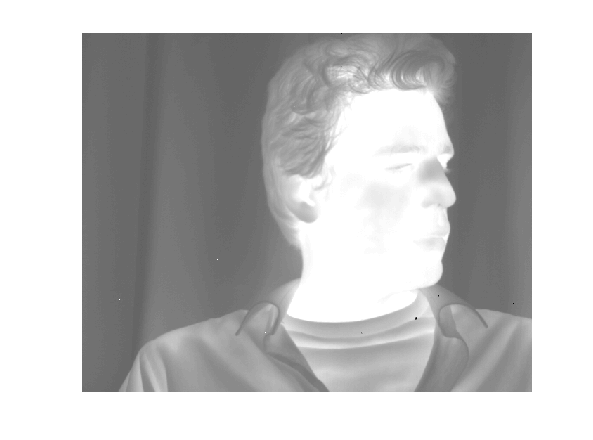

Inside find_faces
Inside dtect_makrs
Inside get_square_box


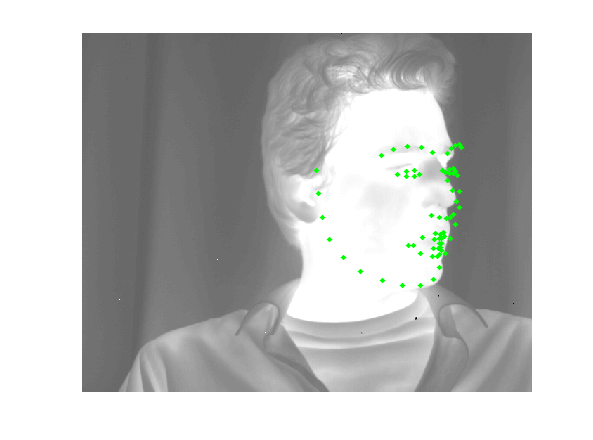

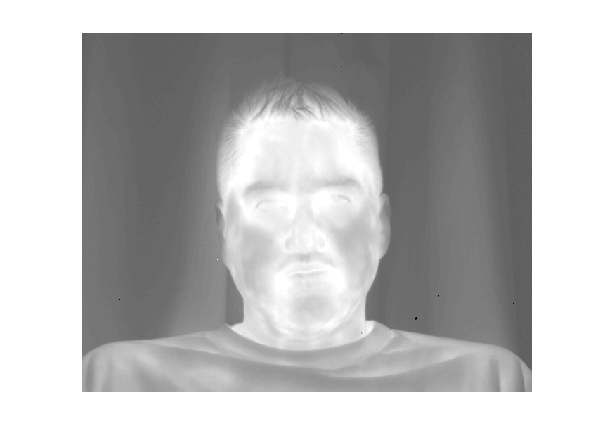

Inside find_faces
Inside dtect_makrs
Inside get_square_box


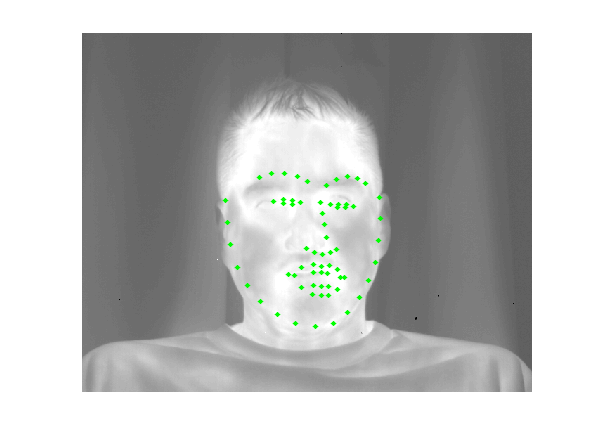

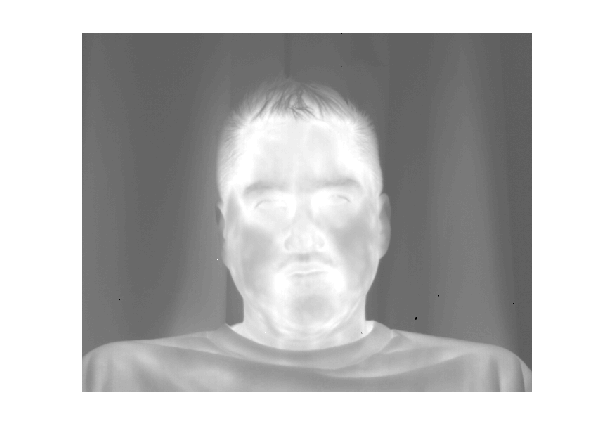

Inside find_faces
Inside dtect_makrs
Inside get_square_box


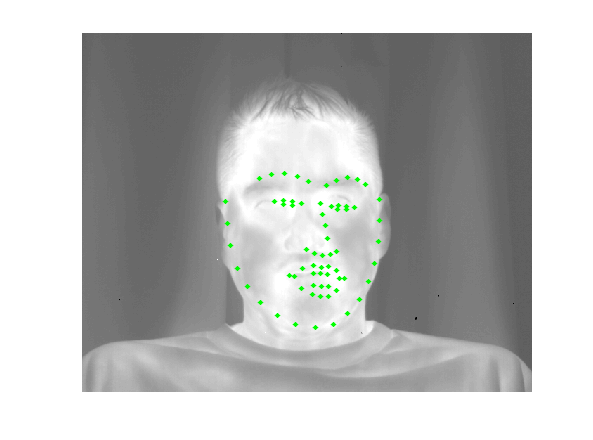

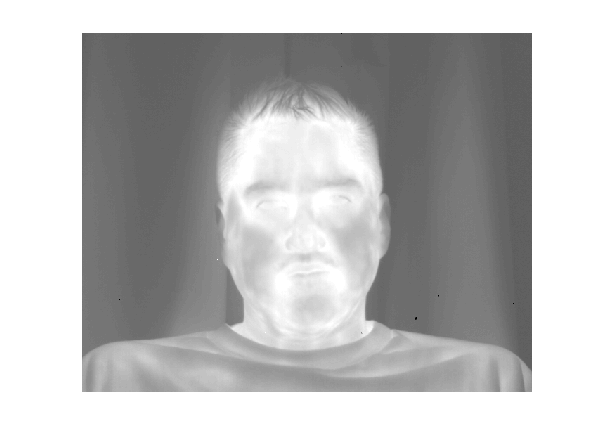

Inside find_faces
Inside dtect_makrs
Inside get_square_box


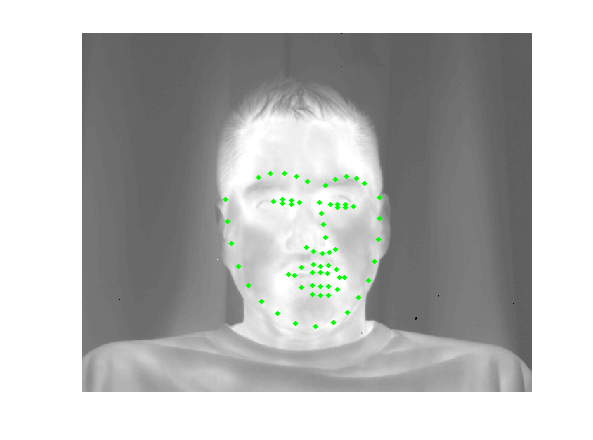

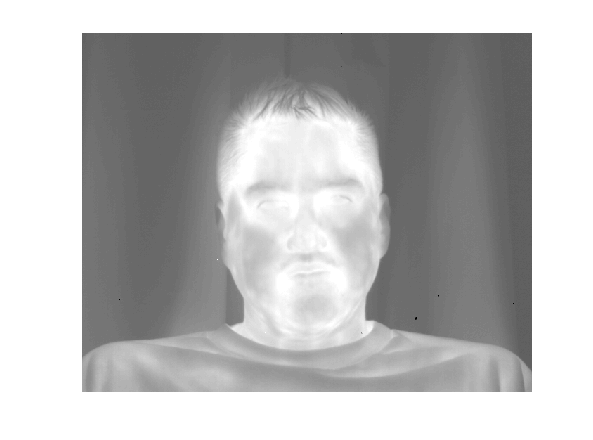

Inside find_faces
Inside dtect_makrs
Inside get_square_box


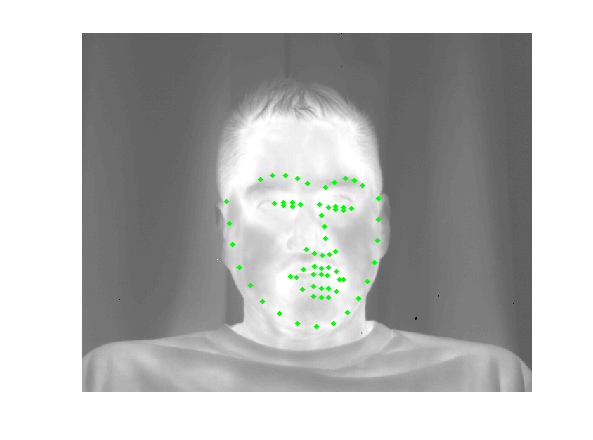

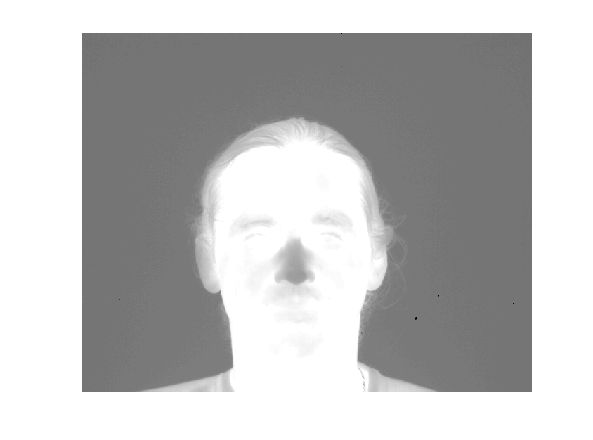

Inside find_faces
Inside dtect_makrs
Inside get_square_box


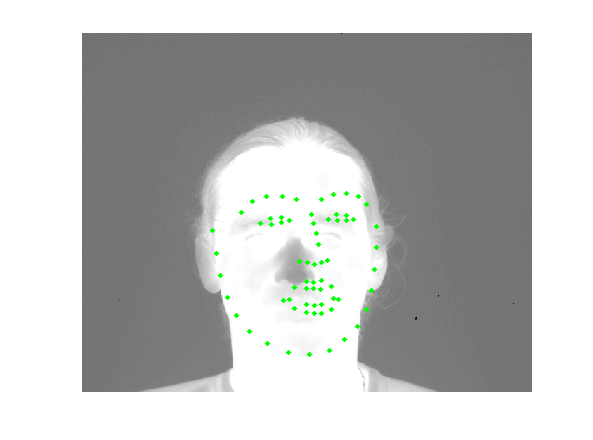

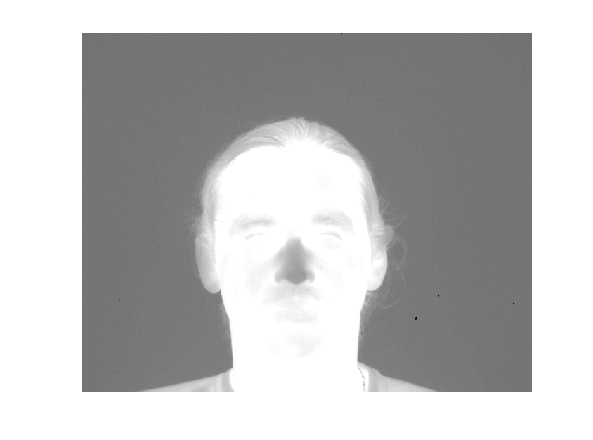

Inside find_faces
Inside dtect_makrs
Inside get_square_box


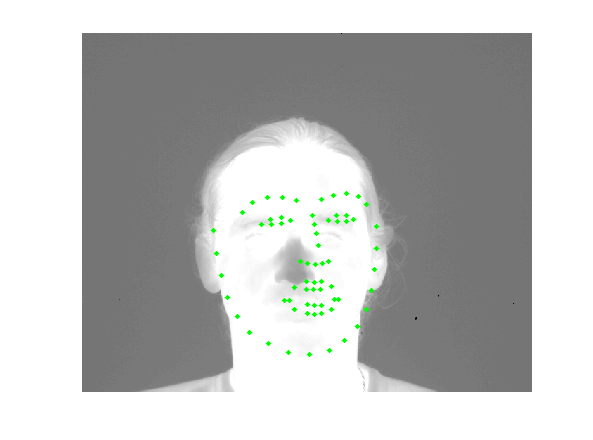

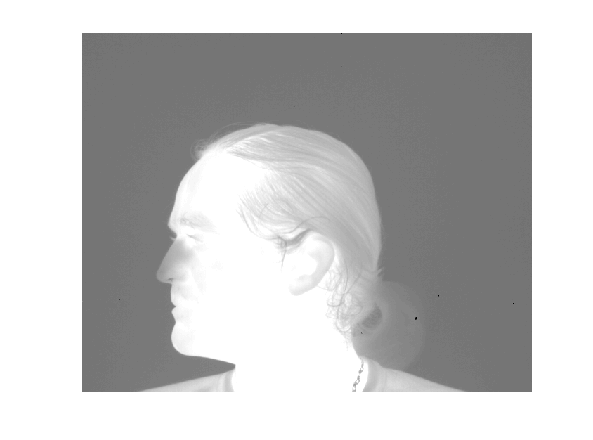

Inside find_faces
Inside dtect_makrs
Inside get_square_box


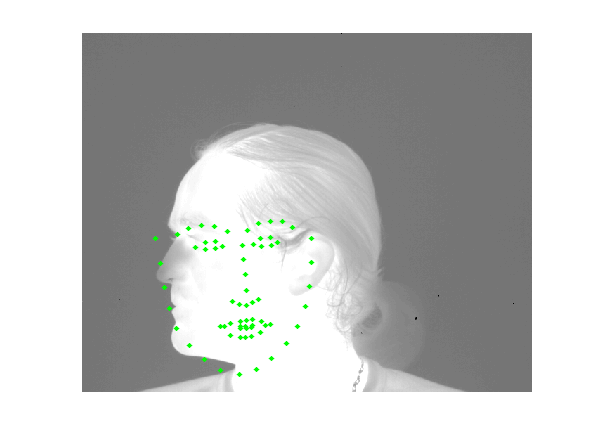

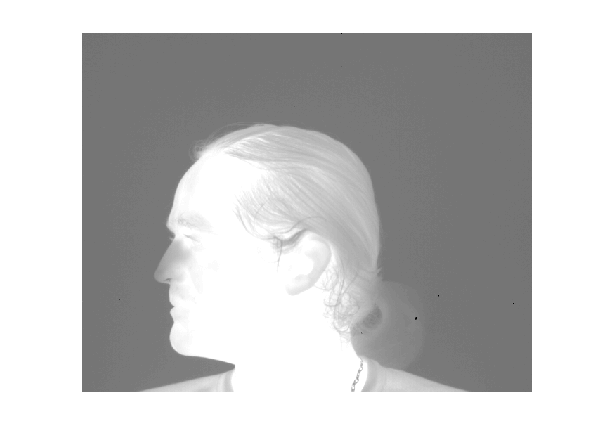

Inside find_faces
Inside dtect_makrs
Inside get_square_box


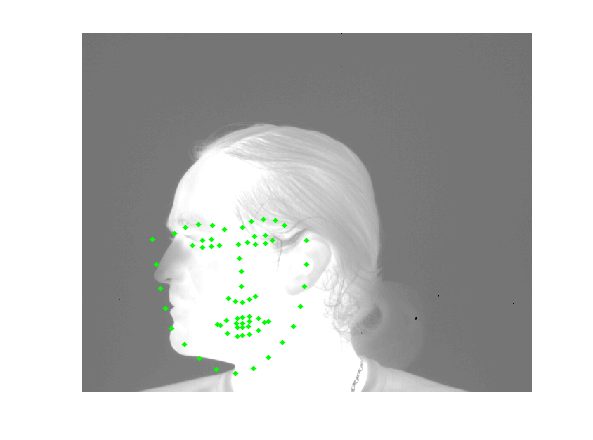

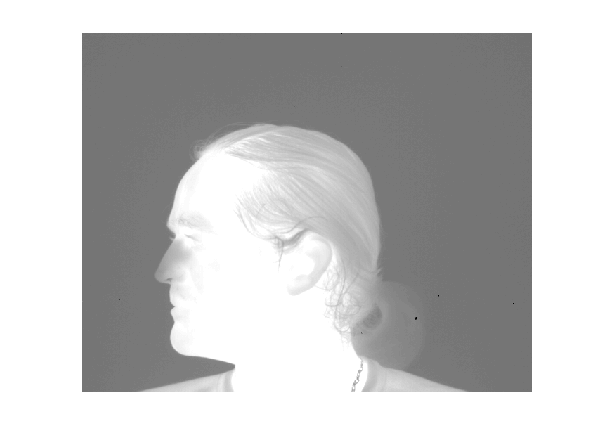

Inside find_faces
Inside dtect_makrs
Inside get_square_box


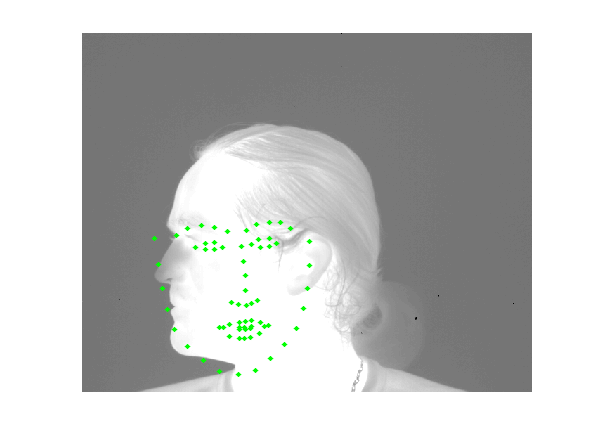

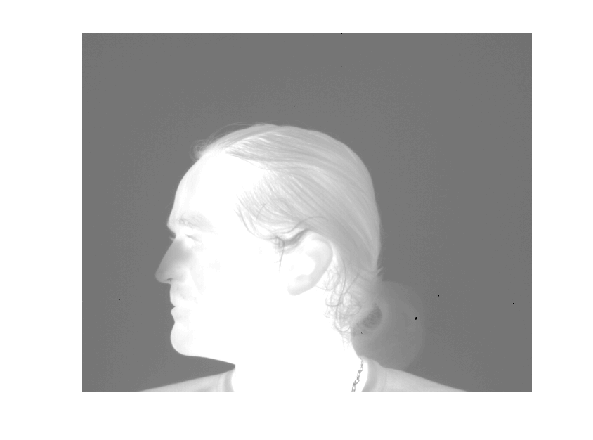

Inside find_faces
Inside dtect_makrs
Inside get_square_box


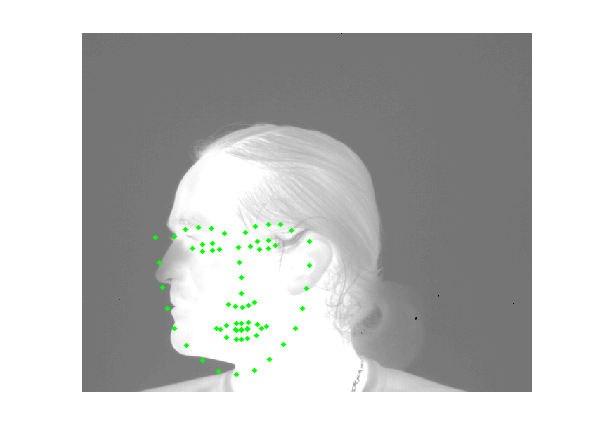

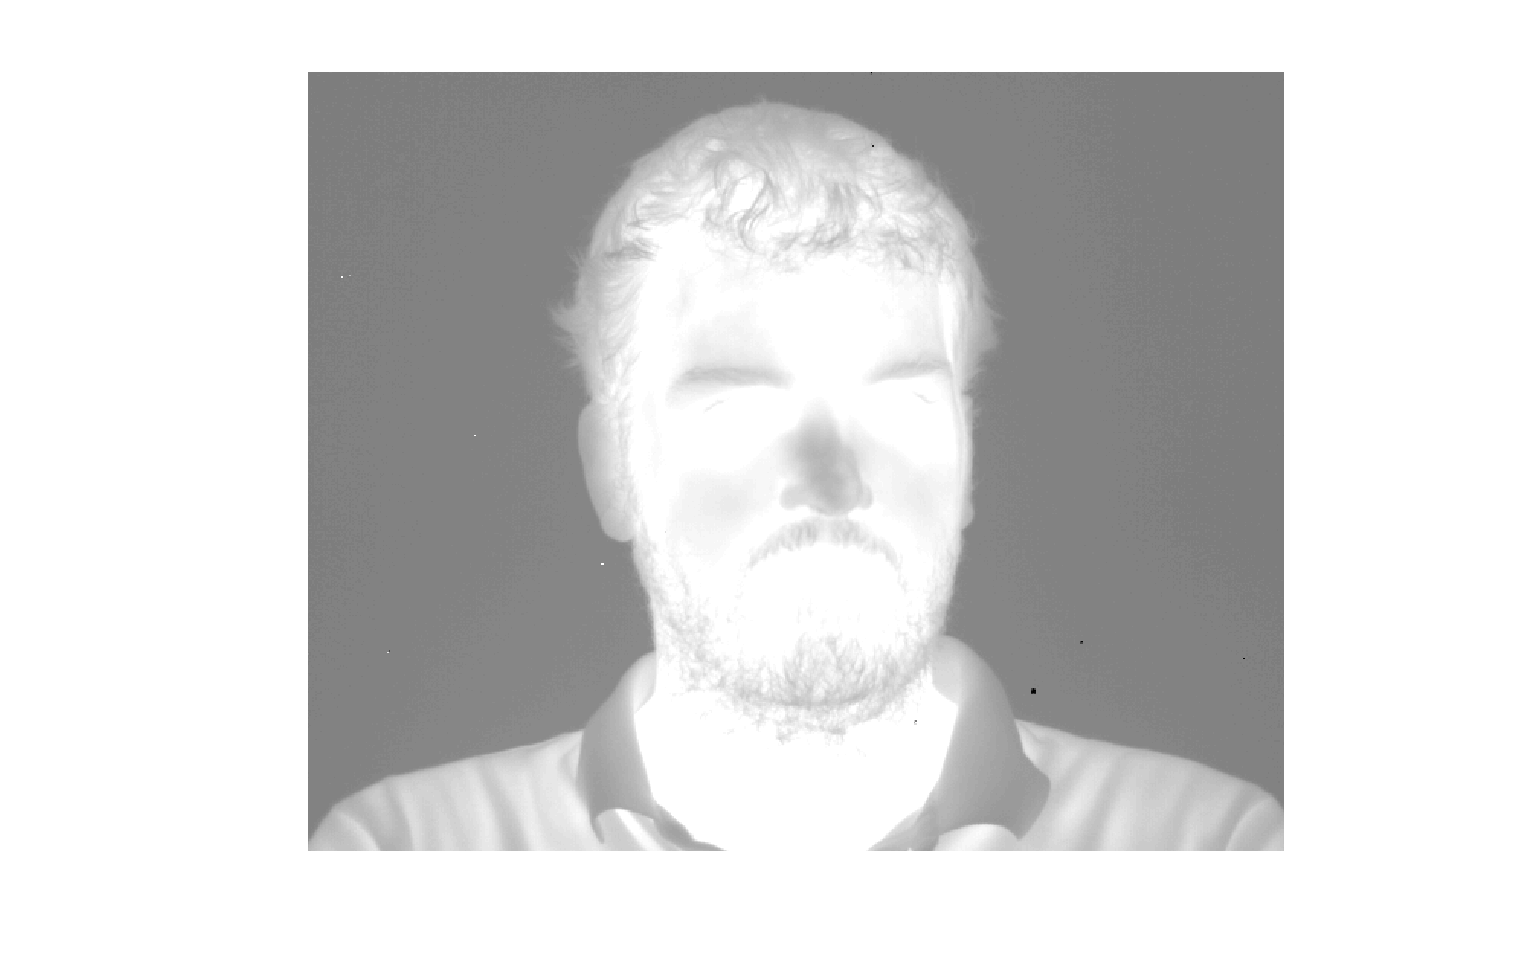

Inside find_faces
Inside dtect_makrs
Inside get_square_box


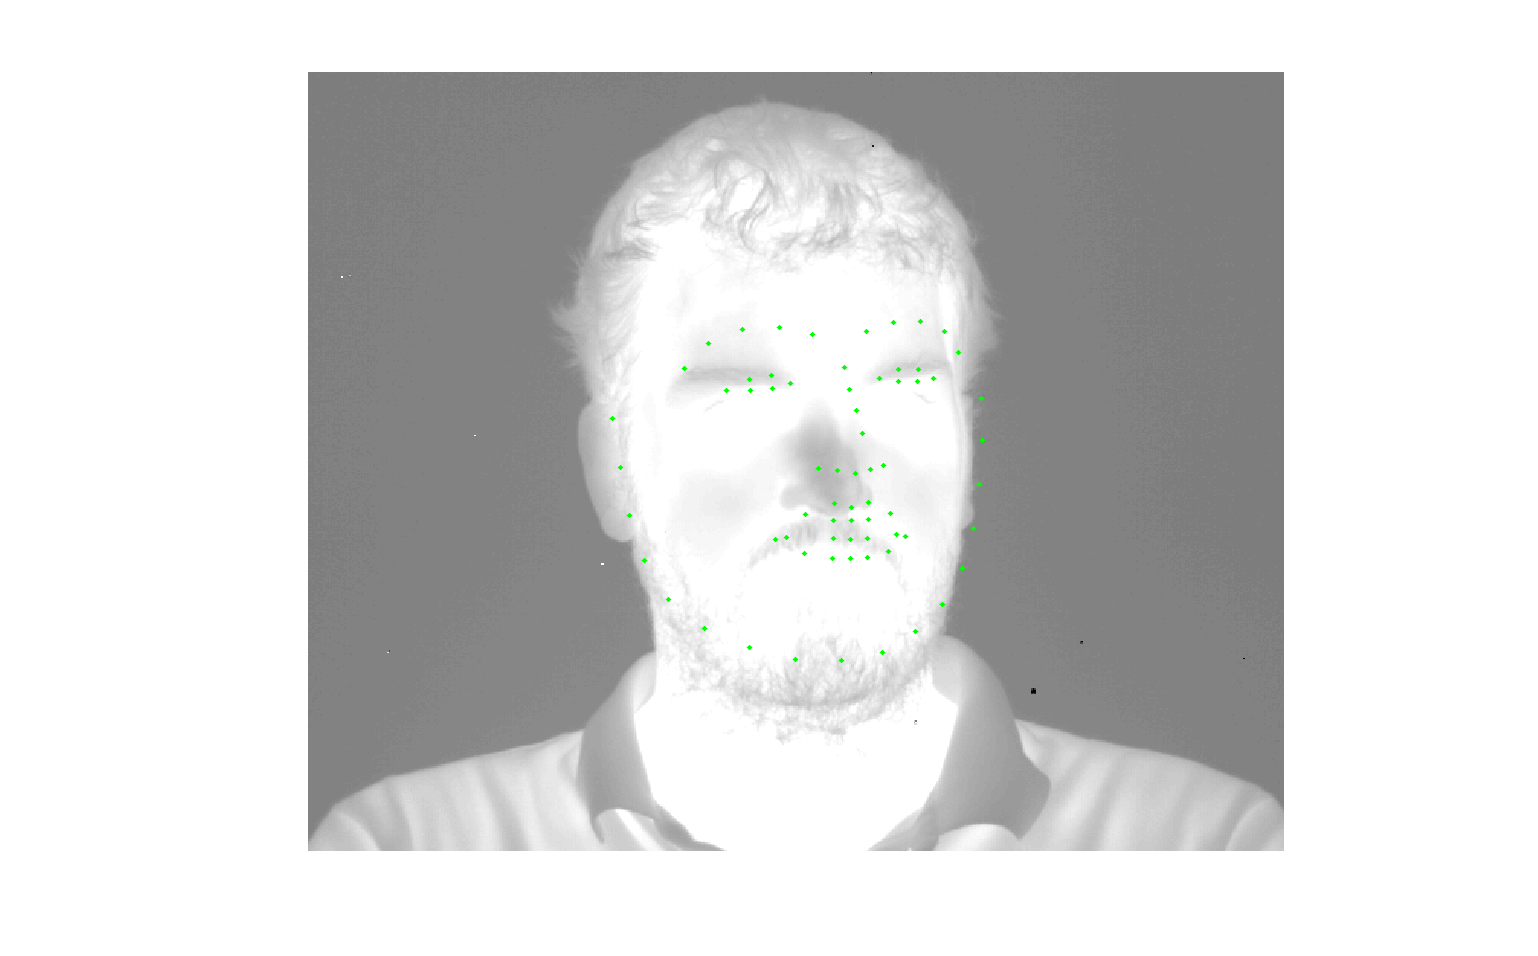

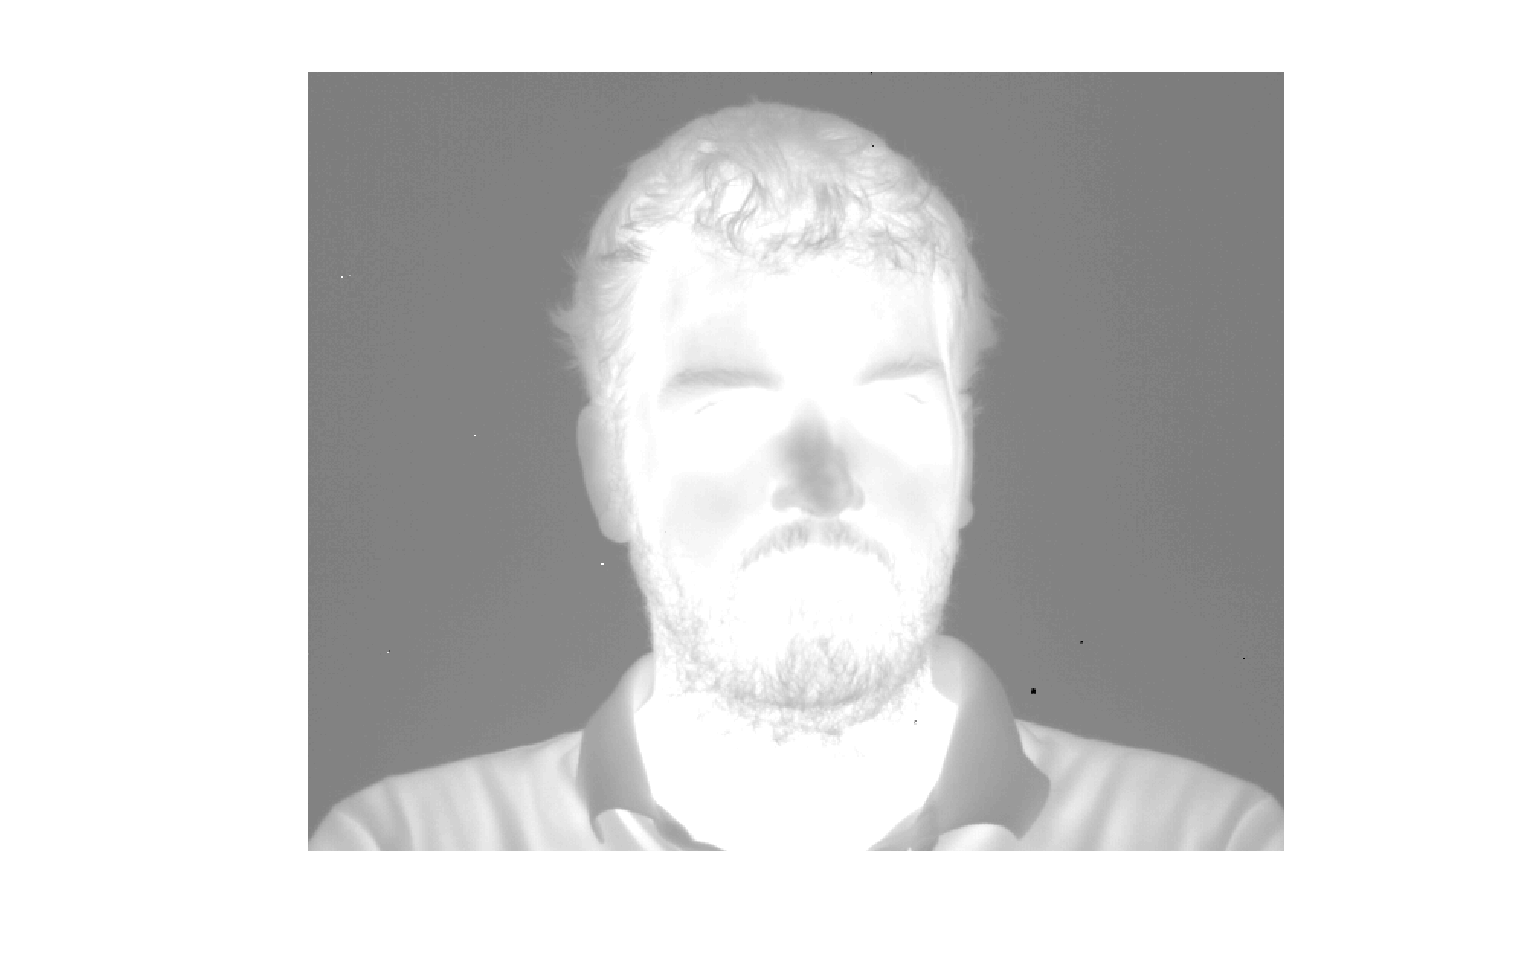

Inside find_faces
Inside dtect_makrs
Inside get_square_box


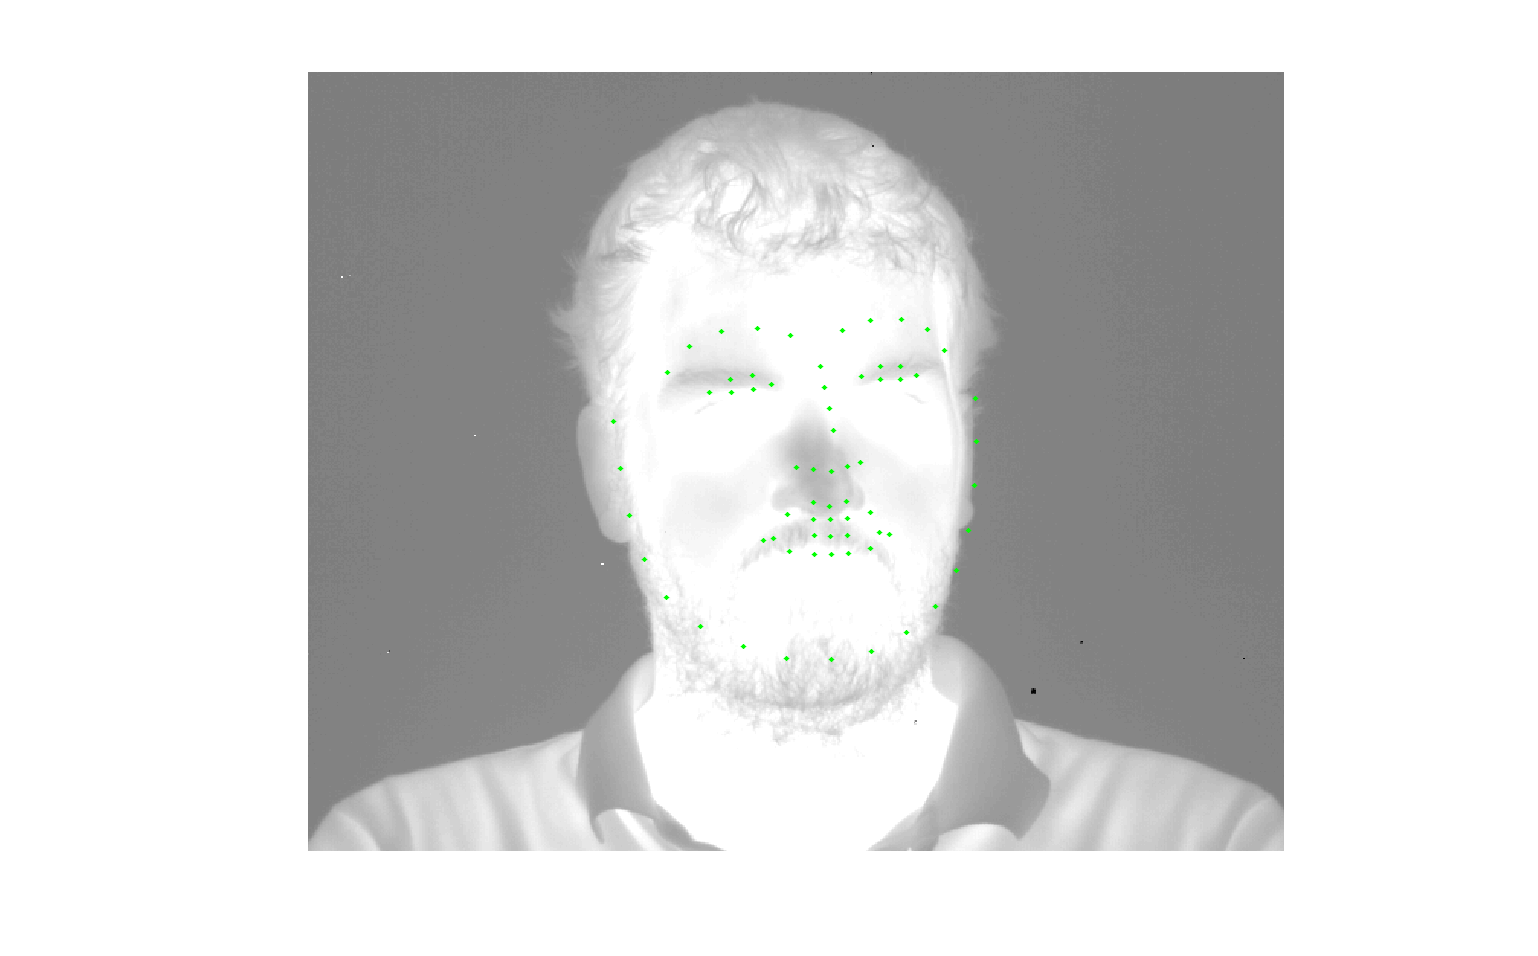

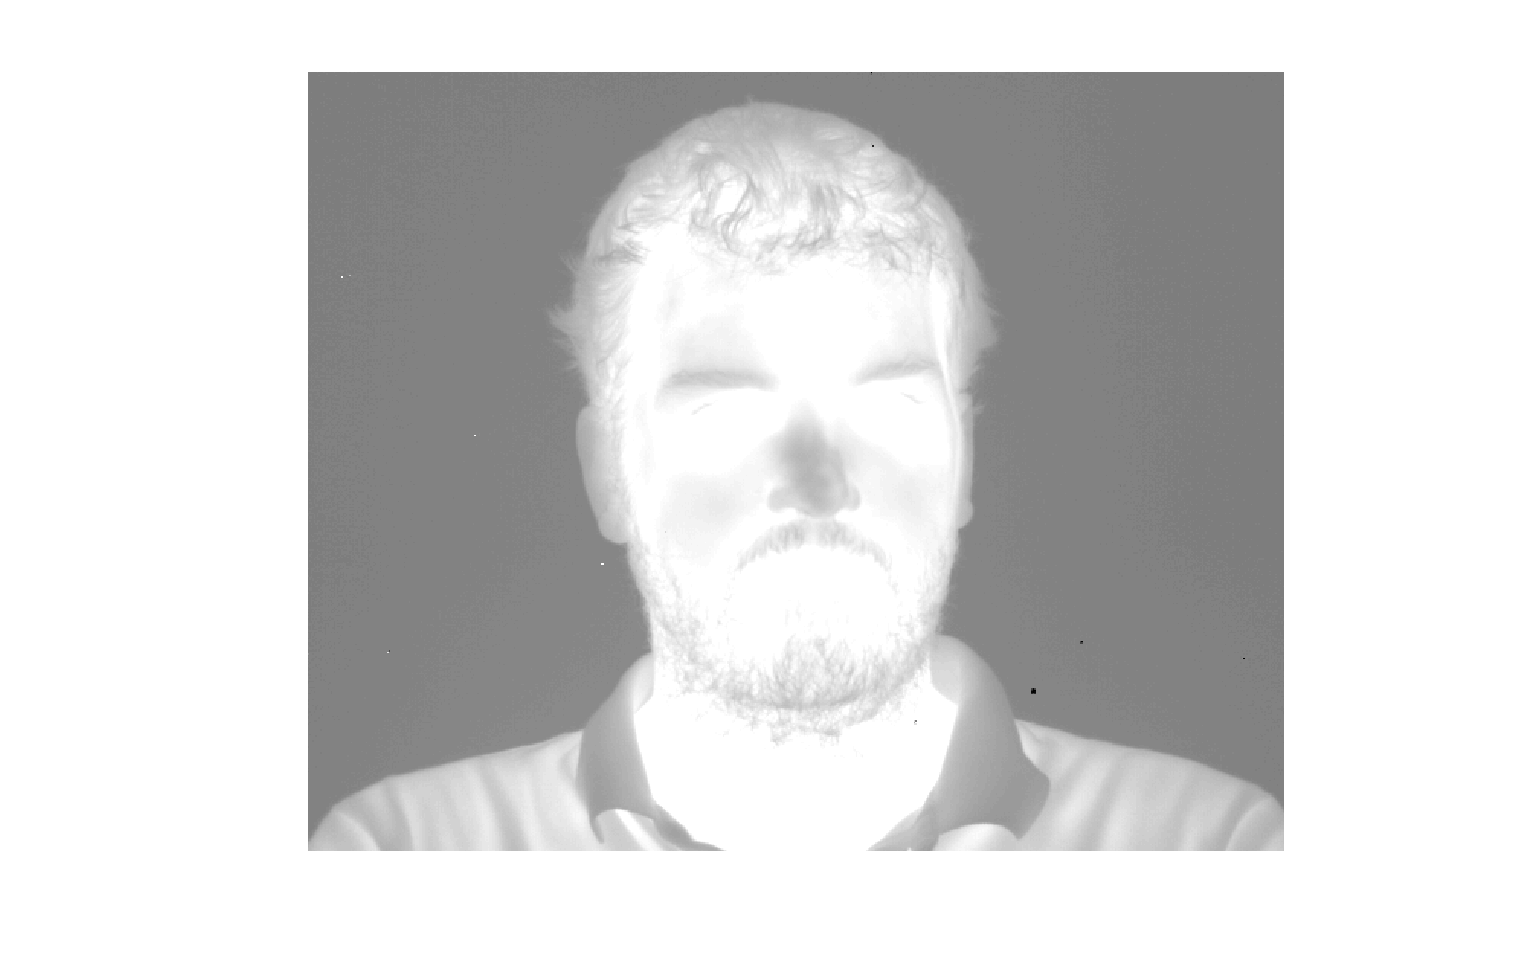

Inside find_faces
Inside dtect_makrs
Inside get_square_box


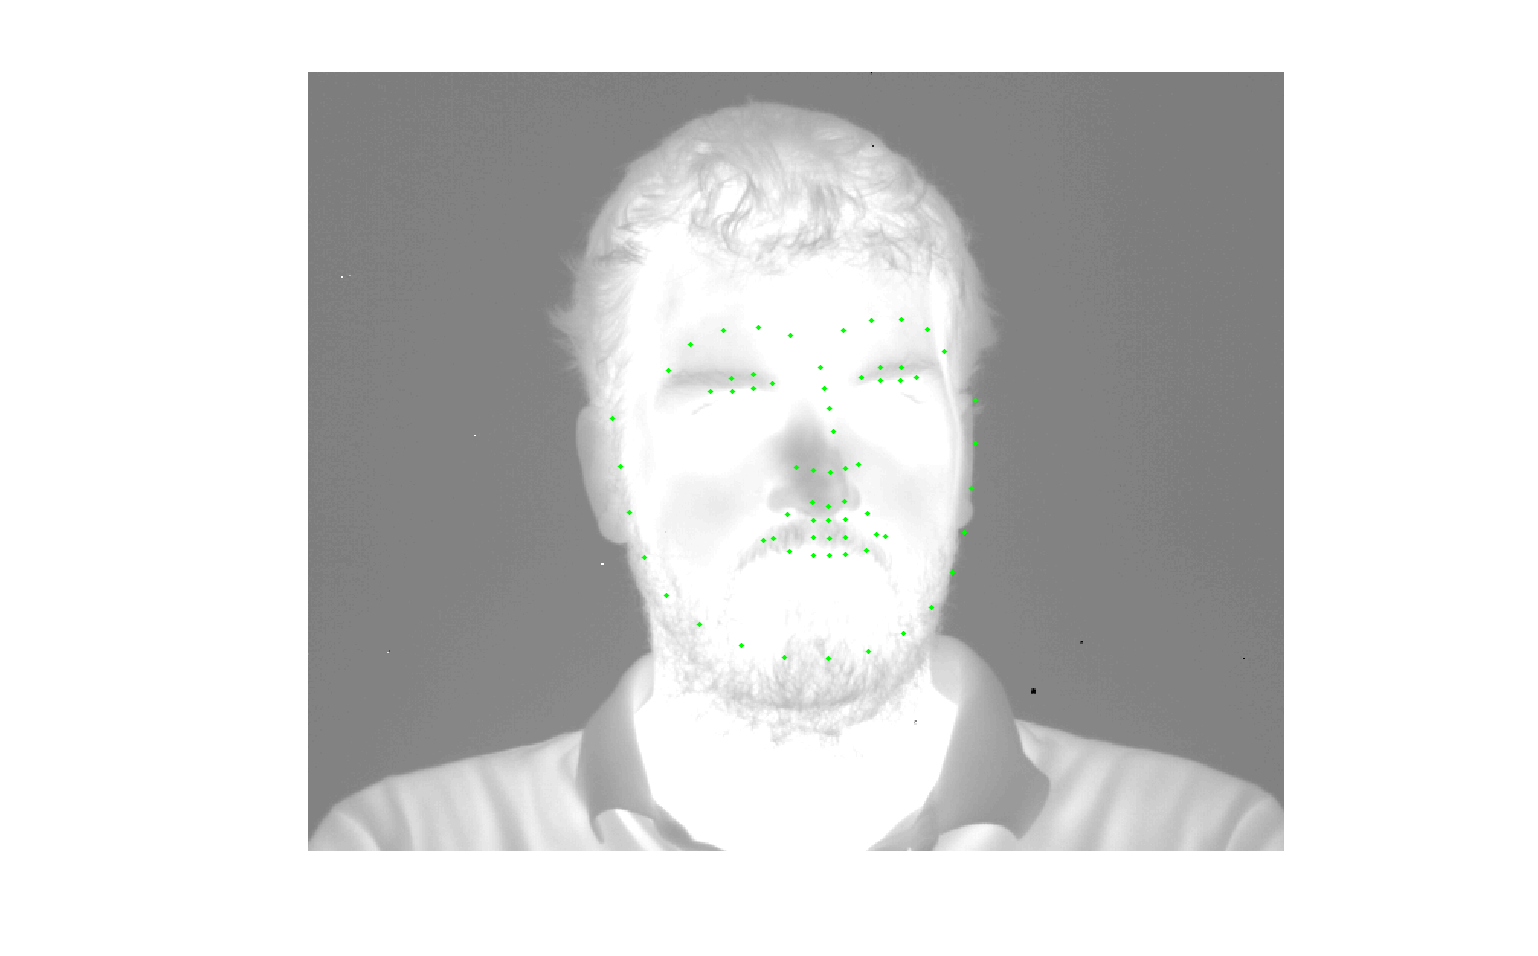

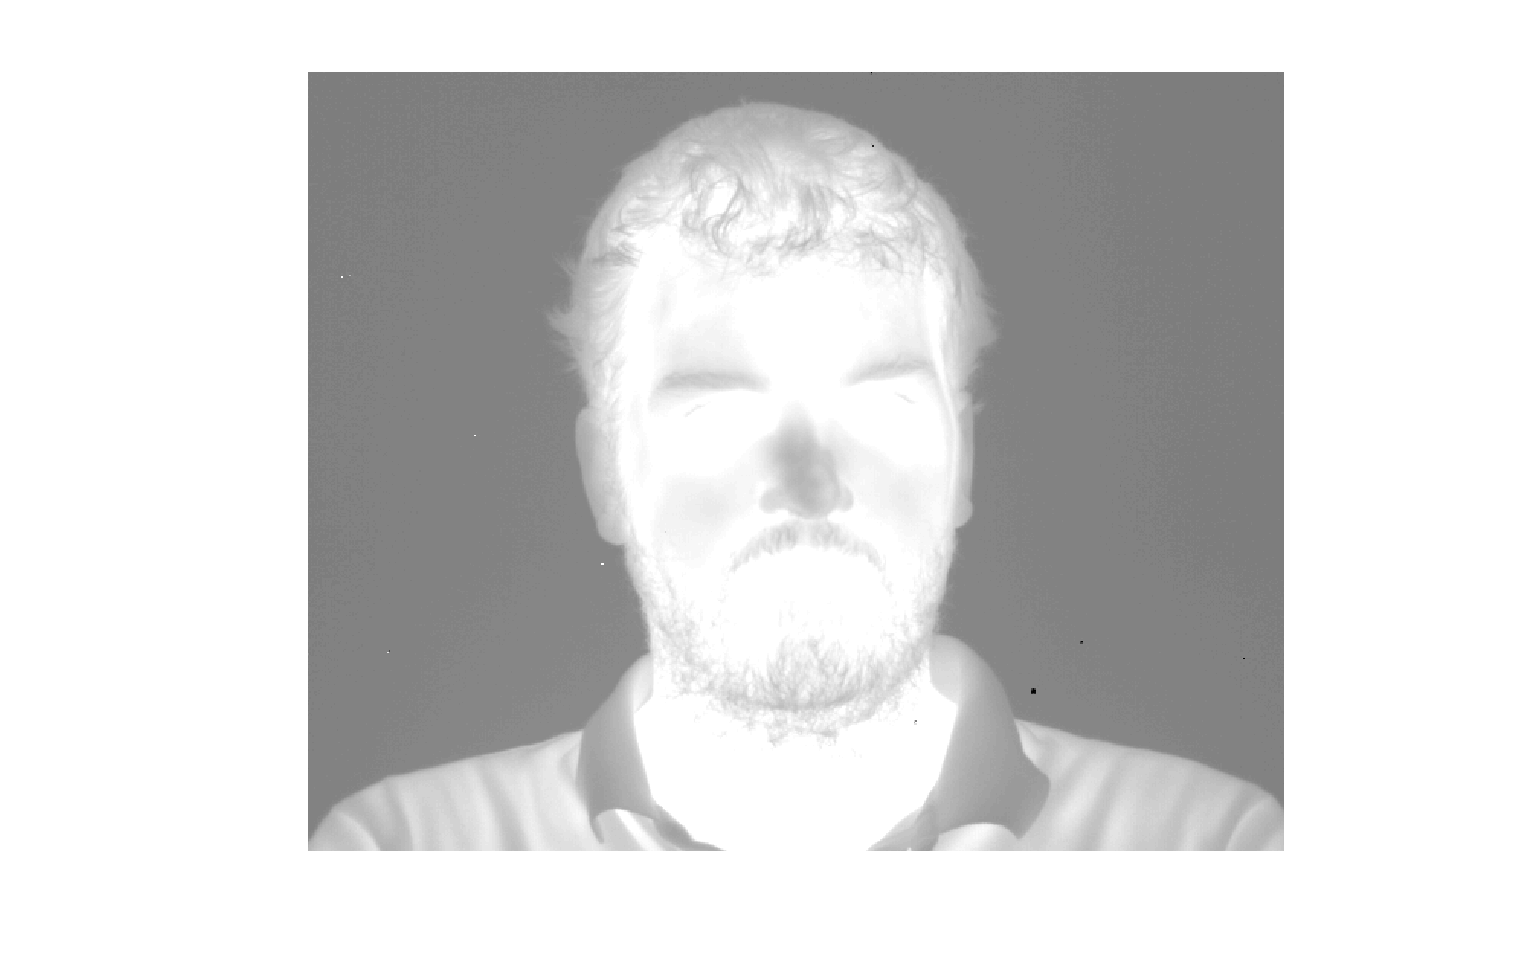

Inside find_faces
Inside dtect_makrs
Inside get_square_box


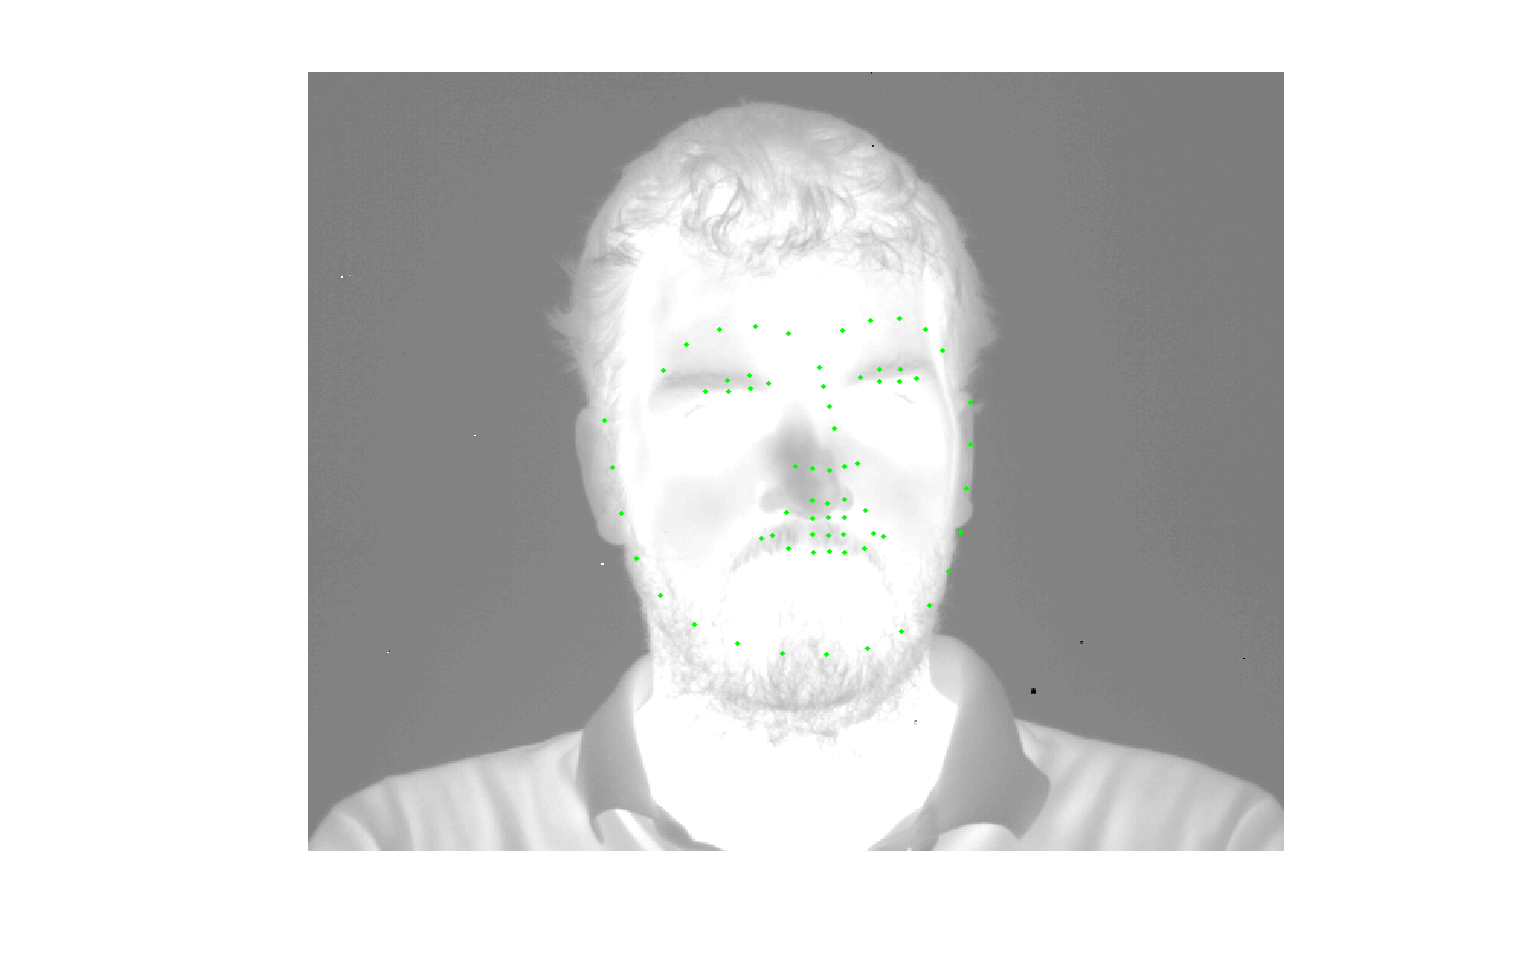

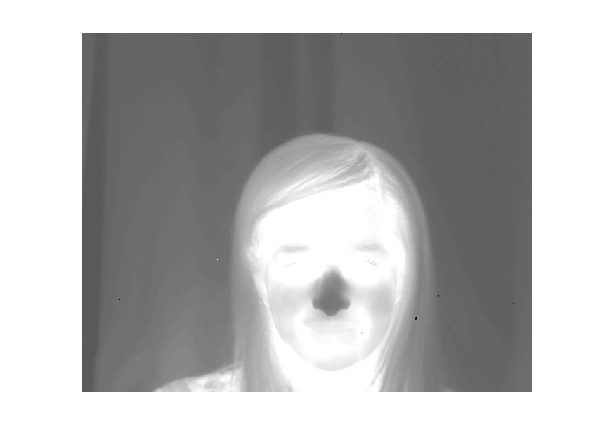

Inside find_faces
Inside dtect_makrs
Inside get_square_box


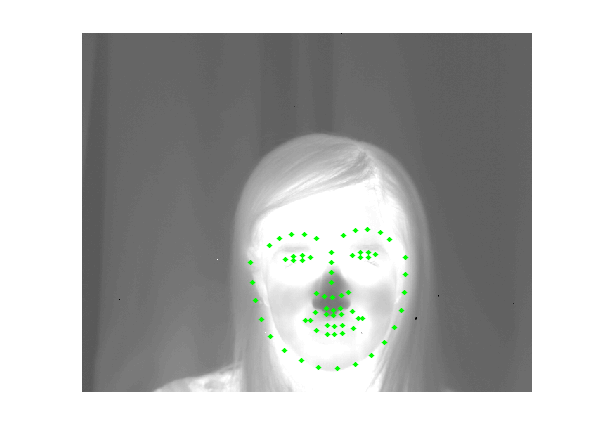

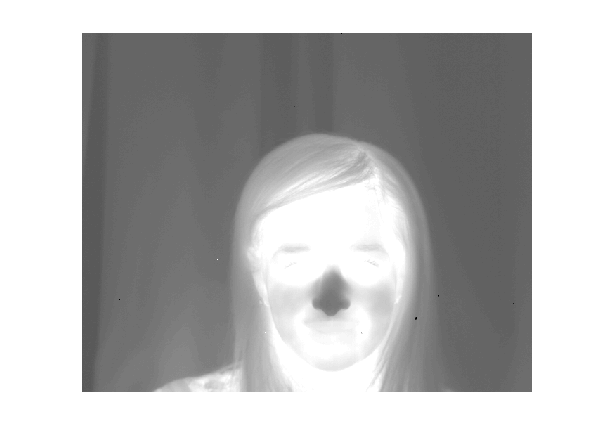

Inside find_faces
Inside dtect_makrs
Inside get_square_box


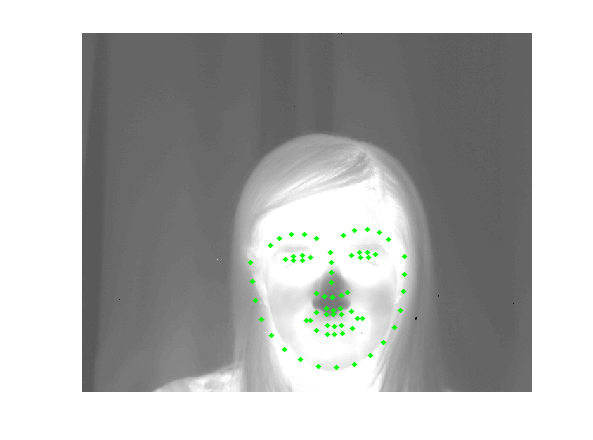

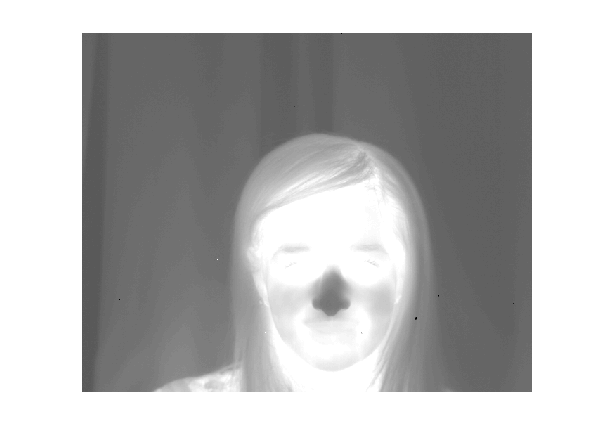

Inside find_faces
Inside dtect_makrs
Inside get_square_box


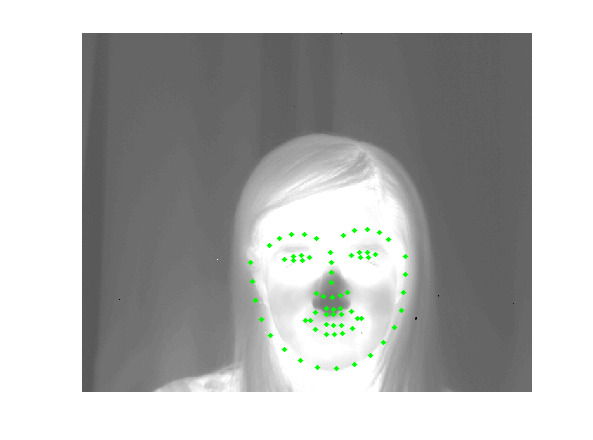

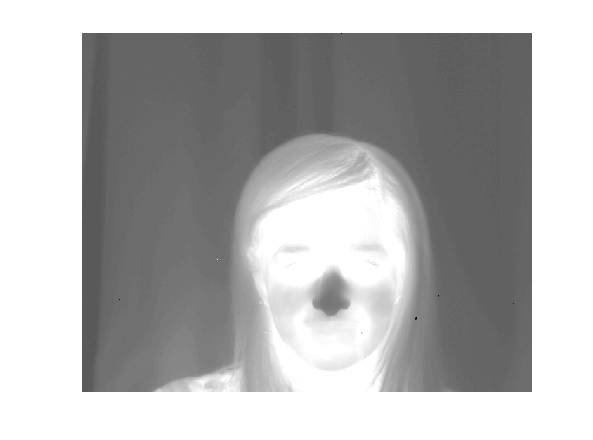

Inside find_faces
Inside dtect_makrs
Inside get_square_box


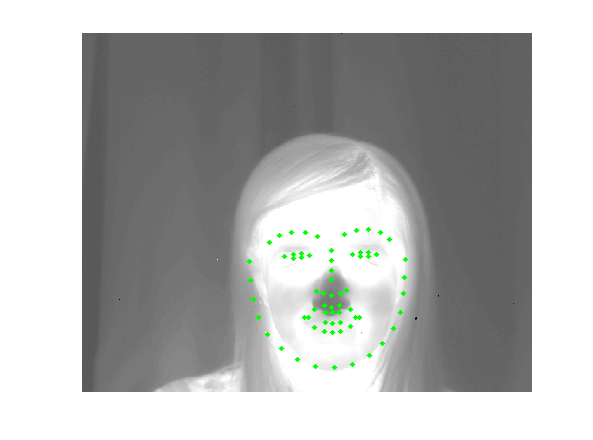

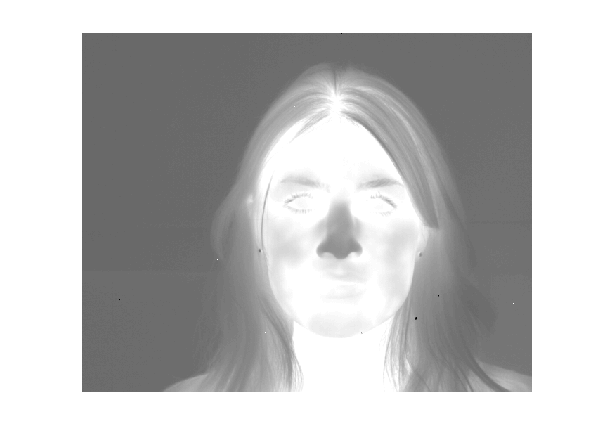

Inside find_faces
Inside dtect_makrs
Inside get_square_box


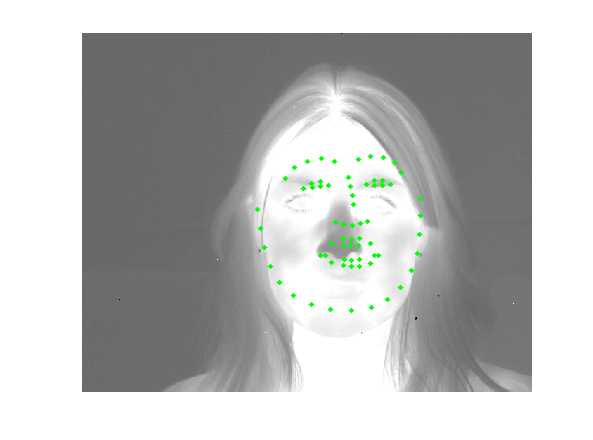

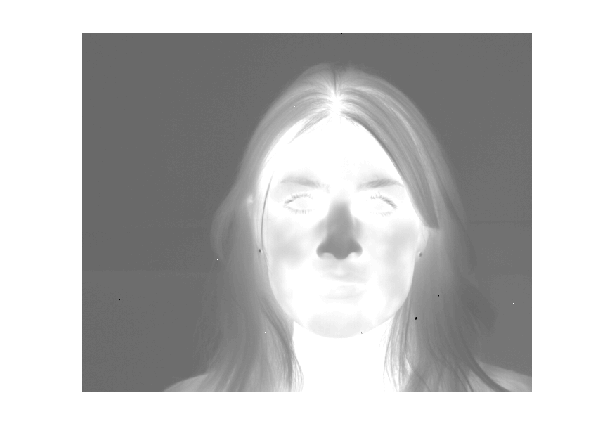

Inside find_faces
Inside dtect_makrs
Inside get_square_box


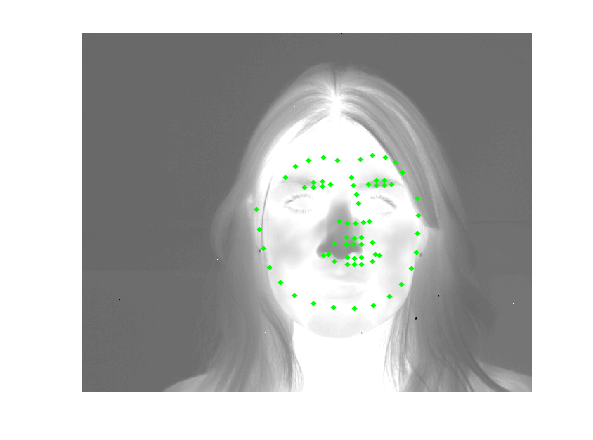

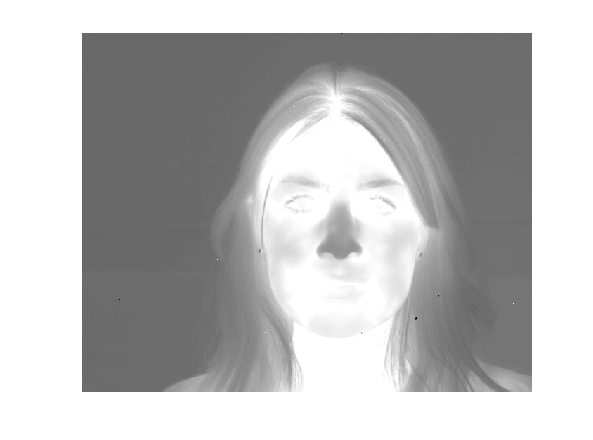

Inside find_faces
Inside dtect_makrs
Inside get_square_box


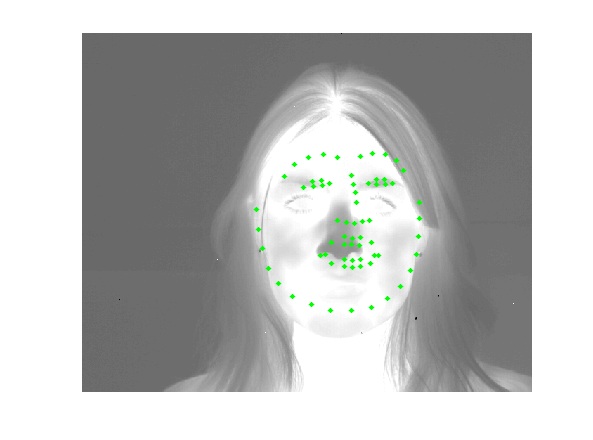

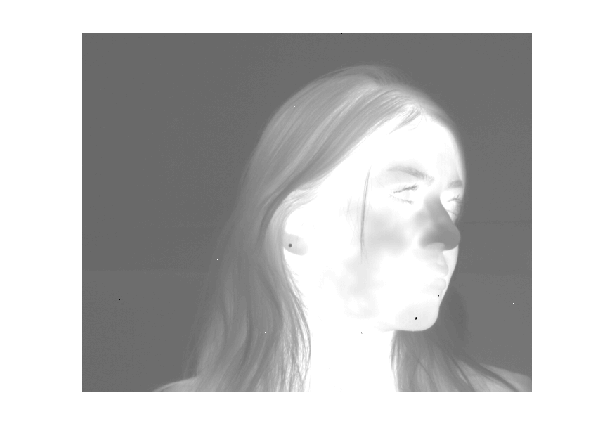

Inside find_faces
Inside dtect_makrs
Inside get_square_box


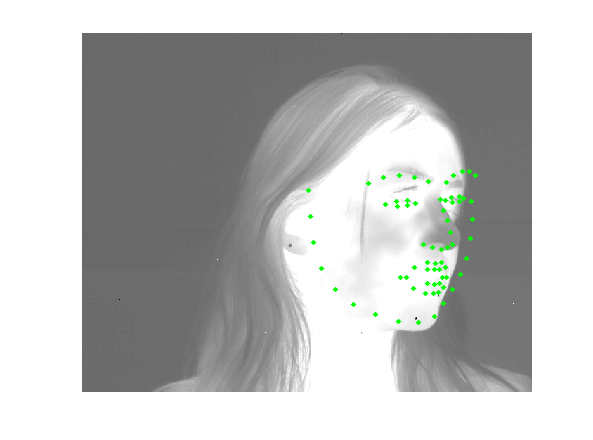

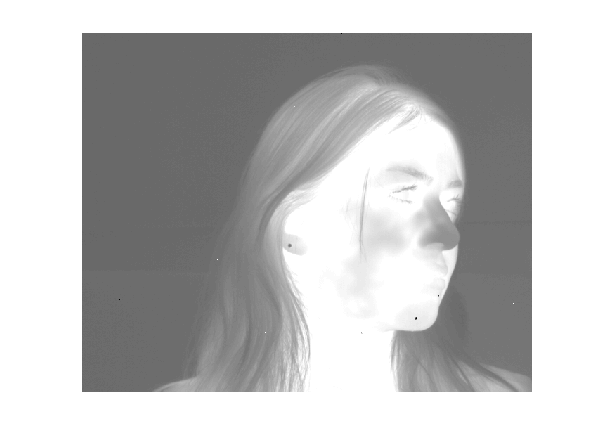

Inside find_faces
Inside dtect_makrs
Inside get_square_box


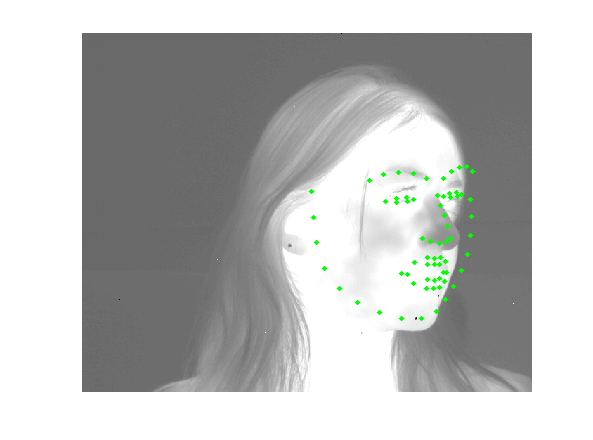

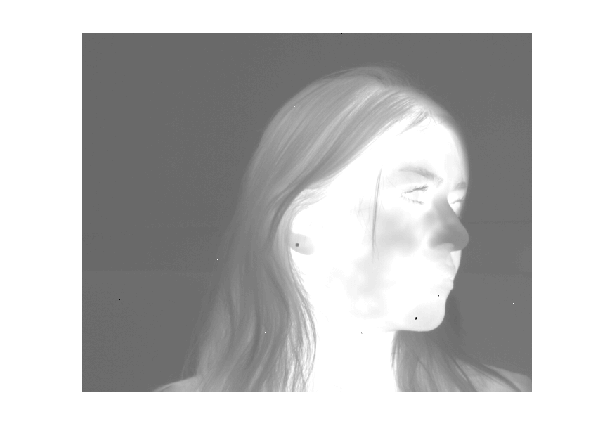

Inside find_faces
Inside dtect_makrs
Inside get_square_box


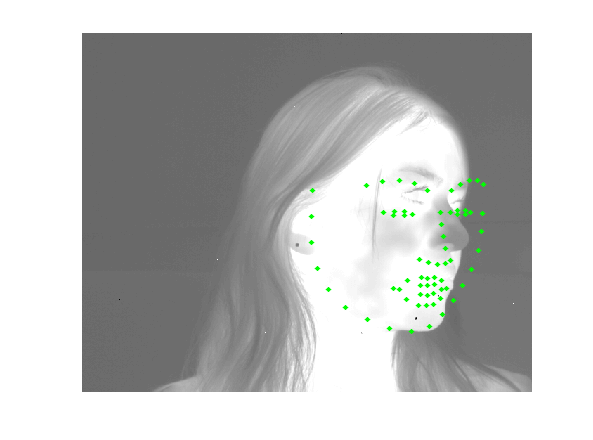

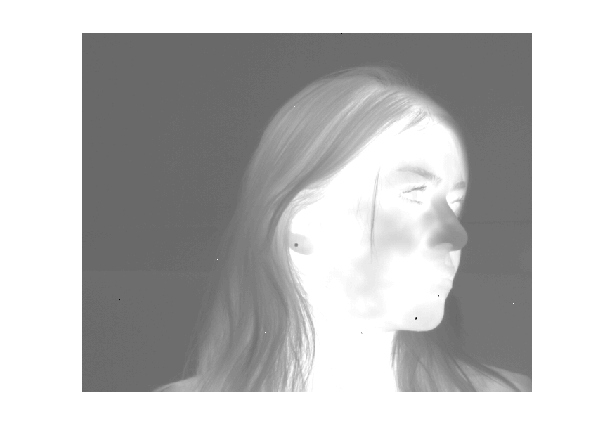

Inside find_faces
Inside dtect_makrs
Inside get_square_box


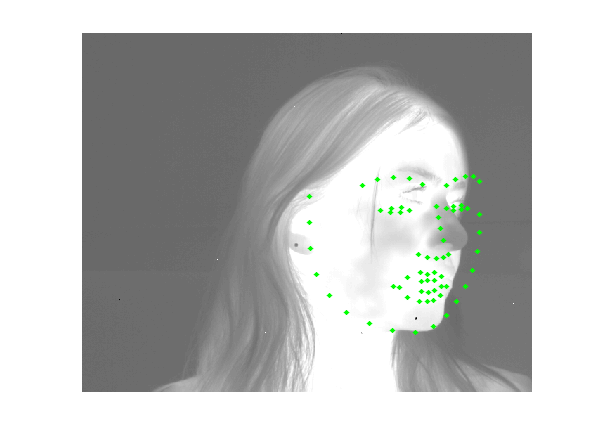

In [ ]:
face_model = get_face_detector()
landmark_model = get_landmark_model()

for img in images:
  cv2_imshow(img)
  rects = find_faces(img, face_model)
  for rect in rects:
    marks = detect_marks(img, landmark_model, rect)
    draw_marks(img, marks)
  cv2_imshow(img)

